'1.11.1'

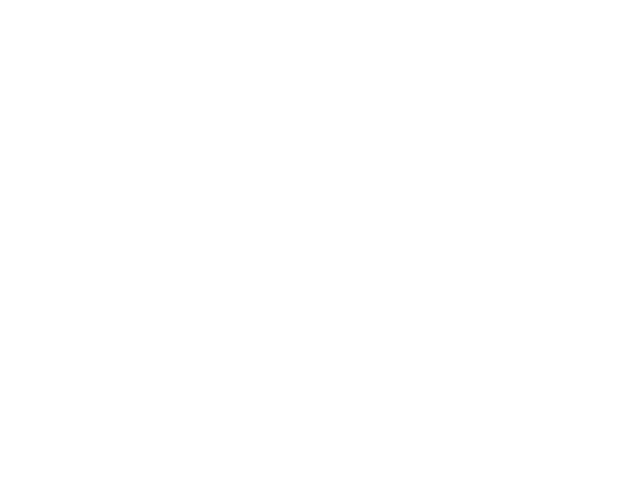

In [1]:
#imports
%load_ext autoreload
%autoreload 2
%matplotlib widget
import mkl
mkl.set_num_threads(40)
import matplotlib
#necessary for plotly interactivity. dont ask me why
#matplotlib.use('nbagg')
import numpy as np
import scipy as sp 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#from scipy import special
from random import gauss
#import hdf5storage
import h5py
import timeit
#from numba import jit
#from sympy.solvers.solveset import nonlinsolve
#from sympy.core.symbol import symbols
#from sympy import exp
from scipy import stats, io, sparse
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from core.analysis import *
from core.simulation import *
import similaritymeasures as sm
sp.__version__

# Construct connectome (no need to rerun)

In [ ]:
#(if needed) construct some necessary properties from the 'Fibers' matlab data
#note that the function is set to utilize the data in 'fgCC', following selen's instruction
#however, another fiber dataset is present inside 'Fibers', called 'fg'.
#the other dataset can be selected manually from inside the function
construct_fibers_from_data(
                #data from Selen Atasoy
                filepath_data='G:/Macbook Stuff/Downloads/NeuralFieldModelv2/100307_Laplace.mat',
                filepath_Fibers='G:/Macbook Stuff/Downloads/Fibers.mat',
                           
                savefiles=True,
                bundle_size=7,
                output_filepath_fiber_edges='G:/Macbook Stuff/Downloads/NeuralFieldModelv2/fg_fiber_bundles.npy',
                output_filepath_fiber_lengths='G:/Macbook Stuff/Downloads/NeuralFieldModelv2/fg_fiber_lengths.npy',                       
                output_filepath_fiber_dist_starts='G:/Macbook Stuff/Downloads/NeuralFieldModelv2/fg_fiber_dist_starts.npy',
                output_filepath_fiber_dist_ends='G:/Macbook Stuff/Downloads/NeuralFieldModelv2/fg_fiber_dist_ends.npy',
                output_filepath_fiber_ends='G:/Macbook Stuff/Downloads/NeuralFieldModelv2/fg_fiber_ends.npy')    

In [10]:
#(if needed) construct the mesh + DTI adjacency directly from the 'faces' and 'fibers' datasets
#the subcortical nodes and edges are excluded at the end of the procedure
#if the 'visual' option is selected, the function also returns datasets in suitable format for plotly
mesh_DTI_adjacency, Xn, Yn, Zn, iN, jN, kN,  Xe, Ye, Ze = construct_adjacency_matrix_from_data(
                                #data from Selen Atasoy
                                filepath_data='/home/aqil/NFModel/100307_Laplace.mat',
                                
                                #results of previous cell
                                filepath_fiber_edges=['/home/aqil/NFModel/fgCCfix_fiber_edges.npy'],#'/home/aqil/NFModel/fg_fiber_edges.npy'],
                                filepath_fiber_lengths=['/home/aqil/NFModel/fgCCfix_fiber_lengths.npy'],#'/home/aqil/NFModel/fg_fiber_lengths.npy'],
                                filepath_fiber_ends=['/home/aqil/NFModel/fgCCfix_fiber_ends.npy'],#'/home/aqil/NFModel/fg_fiber_ends.npy'],
                                
                                include_subcortex=True,
                                add_DTI=True,
                                fiber_speed_factor=50,
    
                                threshold=False,
                                max_dist=10,
                                filepath_fiber_dist_starts=['/home/aqil/NFModel/fgCCfix_fiber_dist_starts.npy'],#'/home/aqil/NFModel/fg_fiber_dist_starts.npy'],
                                filepath_fiber_dist_ends=['/home/aqil/NFModel/fgCCfix_fiber_dist_ends.npy'],#'/home/aqil/NFModel/fg_fiber_dist_ends.npy'],

                                visual=True,
                                plot_subcortex=True,
                                plot_DTI_edges=True)

In [ ]:
f = h5py.File('/home/aqil/NFModel/100307_Laplace.mat', 'r')
CC = np.asarray(f['CC']['restInds'], dtype=int)
indices = np.array([elem[0] for elem in CC])-1

In [ ]:
DTI_edges.shape

In [ ]:
np.save('/home/aqil/NFModel/subcortical_indices.npy', indices)

In [11]:
#(if needed) construct graph Laplacian from mesh data and diagonalize it
binary = False
#this is the same procedure used for regular graphs
AdjMatrix=mesh_DTI_adjacency.toarray()
#convert mm^2 to m^2
if binary:
    AdjMatrix[AdjMatrix>0] = 1
else:
    #convert mm^2 to m^2
    AdjMatrix*=1000000
    
Deg=np.sum(AdjMatrix, axis=0)
Degree_Matrix=sp.sparse.diags(Deg)
regLap = Degree_Matrix - sp.sparse.csc_matrix(AdjMatrix)
Laplacian=-regLap.toarray()

vecs=True

if vecs==False:    
    eigenvalues=np.linalg.eigvalsh(Laplacian)
    eigenvalues[-1]=0
    eigenvalues=eigenvalues[::-1]
    #np.save('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/eigvals_DTI_full_200short.npy', eigenvalues)
else:
    eigenvalues,eigenvectors=np.linalg.eigh(Laplacian)
    #eigenvalues[-1]=0
    #note that the eigenvectors come out 2-normalized
    eigenvalues=eigenvalues[::-1]
    eigenvectors=eigenvectors[:,::-1]
    np.save('/home/aqil/NFModel/eigvals_DTI_fgCCfix_subcortex_dti50.npy', eigenvalues)
    np.save('/home/aqil/NFModel/eigvecs_DTI_fgCCfix_subcortex_dti50.npy', eigenvectors)


# Load previously constructed connectome

In [2]:
#len(np.nonzero(mesh_DTI_adjacency.toarray())[0])/2
#np.shape(mesh_DTI_adjacency.toarray())
f = h5py.File('/home/aqil/NFModel/100307_Laplace.mat', 'r')
CC = np.asarray(f['CC']['restInds'], dtype=int)
indices = np.array([elem[0] for elem in CC])-1
AllVet=np.asarray(f['vertices']['all'])

#u_0=np.heaviside(AllVet[0,indices],0)
f.close()
#no_sub=mesh_DTI_adjacency[indices,:]
#no_sub=no_sub[:,indices]
#len(np.nonzero(no_sub.toarray())[0])/2
#mesh_DTI_adjacency=np.load('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/metric_cortical_DTI_bundles_full_all_fibers.npy')
#mesh_DTI_adjacency=mesh_DTI_adjacency[indices,:]
#mesh_DTI_adjacency=mesh_DTI_adjacency[:,indices]
#mesh_DTI_adjacency.toarray().shape

In [ ]:
##np.save('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/metric_cortical_DTI_bundles_full_all_fibers.npy', mesh_DTI_adjacency)

In [3]:
#Alternatively, if previously known, read eigenvalues and eigenvectors from file
#this is what i used for the thesis. note that it has to be loaded with a minus sign
#eigenvalues_thesis = -np.load('E:/My Documents/Dropbox/Amsterdam Math/Rikkert Hindriks/Graph-Stochastic-Wilson-Cowan-Model/data/eigvals.npy')
#this should be the corresponding eigenvectors. they appear to be 1-normalized
#eigenvectors_thesis = -np.load('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/eigvecs.npy')

#eigenvalues = np.load('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/eigvals_DTI_fgCC_200short.npy')

# eigenvalues = np.load('/home/aqil/NFModel/eigvals_DTI_fgCCfix_200short_metres.npy')
# eigenvectors = np.load('/home/aqil/NFModel/eigvecs_DTI_fgCCfix_200short_metres.npy')

#these are all in metres unless otherwise specified
# eigenvalues = np.load('/home/aqil/NFModel/eigvals_DTI_fgCCfix_fg_subcortex.npy')
# eigenvectors = np.load('/home/aqil/NFModel/eigvecs_DTI_fgCCfix_fg_subcortex.npy')

# eigenvalues = np.load('/home/aqil/NFModel/eigvals_DTI_fgCCfix_fg_subcortex_dti50.npy')
# eigenvectors = np.load('/home/aqil/NFModel/eigvecs_DTI_fgCCfix_fg_subcortex_dti50.npy')

# eigenvalues = np.load('/home/aqil/NFModel/eigvals_DTI_fgCCfix_fg_subcortex_dti1.npy')
# eigenvectors = np.load('/home/aqil/NFModel/eigvecs_DTI_fgCCfix_fg_subcortex_dti1.npy')

#unused
# eigenvalues = np.load('/home/aqil/NFModel/eigvals_DTI_fgCCfix_subcortex_dti1_mm.npy')
# eigenvectors = np.load('/home/aqil/NFModel/eigvecs_DTI_fgCCfix_subcortex_dti1_mm.npy')

# eigenvalues = np.load('/home/aqil/NFModel/eigvals_DTI_fgCCfix_subcortex_dti10.npy')
# eigenvectors = np.load('/home/aqil/NFModel/eigvecs_DTI_fgCCfix_subcortex_dti10.npy')

eigenvalues = np.load('/home/aqil/NFModel/eigvals_DTI_fgCCfix_subcortex_dti50.npy')
eigenvectors = np.load('/home/aqil/NFModel/eigvecs_DTI_fgCCfix_subcortex_dti50.npy')

#eigenvalues = -np.load('E:/My Documents/Dropbox/Amsterdam Math/Rikkert Hindriks/Graph-Stochastic-Wilson-Cowan-Model/data/eigvals.npy')
len(eigenvalues)
#np.save('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/eigvals_DTI_fgCC_200short_metres.npy', eigenvalues)
#print(eigenvalues)
#print(eigenvalues2)

20484

In [4]:
#Set parameters and bounds for minimization algorithms
Graph_Kernel='Damped Wave'

aEE, bnds_aEE = 140, (0,1e6)
aIE, bnds_aIE = 155, (0,1e6)
aEI, bnds_aEI = 165, (0,1e6)
aII, bnds_aII = 140, (0,1e6)
dE, bnds_dE = 2, (0,1e6)
dI, bnds_dI = 2, (0,1e6)
P, bnds_P = 0, (0,1e6)
Q, bnds_Q = 0, (0,1e6)
sEE, bnds_sEE = 6, (0,1e6)
sIE, bnds_sIE = 10, (0,1e6)
sEI, bnds_sEI = 10, (0,1e6)
sII, bnds_sII = 50, (0,1e6)
#D, bnds_D = 1, (0.1,10)             #unchanged
tE, bnds_tE = 1, (0,1e6)          
tI, bnds_tI = 1, (0,1e6)          
#snE, bnds_snE = 1, (1,10)        #unchanged
#snI, bnds_snI = 1, (1,10)         #unchanged

initial_guess=[aEE,aIE,aEI,aII,dE,dI,P,Q,sEE,sIE,sEI,sII,tE,tI]#,snE])#,snI]) 
bnds=[bnds_aEE,bnds_aIE,bnds_aEI,bnds_aII,bnds_dE,bnds_dI,bnds_P,bnds_Q,bnds_sEE,bnds_sIE,bnds_sEI,bnds_sII,bnds_tE,bnds_tI]#,bnds_snE]#,bnds_snI]


if Graph_Kernel == 'Damped Wave':
    aDW_EE, bnds_aDW_EE = 0, (0,1e6)
    aDW_IE, bnds_aDW_IE = 0, (0,1e6)
    aDW_EI, bnds_aDW_EI = 0, (0,1e6)
    aDW_II, bnds_aDW_II = 0, (0,1e6)
    bDW_EE, bnds_bDW_EE = 0, (0,1e6)
    bDW_IE, bnds_bDW_IE = 0, (0,1e6)
    bDW_EI, bnds_bDW_EI = 0, (0,1e6)
    bDW_II, bnds_bDW_II = 0, (0,1e6)
    initial_guess += [aDW_EE,aDW_IE,aDW_EI,aDW_II,bDW_EE,bDW_IE,bDW_EI,bDW_II]
    bnds += [bnds_aDW_EE,bnds_aDW_IE,bnds_aDW_EI,bnds_aDW_II,bnds_bDW_EE,bnds_bDW_IE,bnds_bDW_EI,bnds_bDW_II]

In [5]:

#thesis values
first_k=2
last_k=5000
thesis_spatial_spectrum = 15*(np.arange(first_k,last_k)**(-0.3))

#post-thesis work
first_k=3
last_k=len(eigenvalues)
x_t = np.log(np.arange(first_k,last_k))
new_spatial_spectrum = 10**(-0.012*x_t**(2.2) + 0.6 + 0.5*x_t**(-0.3))#0.02*x_t**(1.1)+1.1)# + x_t**(-1.5)+10)
#more similar to fluctuations power data from selen
new_spatial_spectrum = 10**(-0.018*x_t**(2.2) + 0.5 + 0.5*x_t**(-0.3))

#empirical SPS
first_k=1
last_k=10000#len(eigenvalues)
f = sp.io.loadmat('/home/aqil/NFModel/100307_REST1_LR_selenyeo10k.mat')

if len(eigenvalues)==18715:
    timecourse = np.nan_to_num(np.concatenate((f['selenyeo10kts_lh'],f['selenyeo10kts_rh']), axis=0)[indices])
else:
    timecourse = np.nan_to_num(np.concatenate((f['selenyeo10kts_lh'],f['selenyeo10kts_rh']), axis=0))
#errors = np.nan_to_num(np.concatenate((f['selenyeo10kts_lh_stderr'],f['selenyeo10kts_rh_stderr']), axis=0)[indices])

#the Laplace coefficient of the zero-mean timecourses
coeffs = np.dot(eigenvectors.T,(timecourse-timecourse.mean(1)[...,np.newaxis]))
#the Laplace coefficient of the z-scored timecourses
#coeffs_zscore = np.dot(eigenvectors.T,np.nan_to_num(sp.stats.zscore(timecourse, axis=1)))

#here i define logspace binning
bins = np.unique(np.logspace(np.log10(first_k), np.log10(last_k), num=300, dtype=int))[:-1]
bins_positions = np.array([elem.mean() for elem in np.array_split(np.arange(first_k,last_k), bins)])
def median_binning(data,bins):
    return np.array([np.median(elem) for elem in np.array_split(data, bins)])

In [ ]:
#from matplotlib import cm
#colors = cm.get_cmap('RdBu')(np.linspace(0,1,220))

In [ ]:
# plt.figure()
# for c,i in enumerate(np.arange(0,1100,5)):
    
#     empirical_SPS=(np.abs(coeffs[:,i:(i+60)])**2).mean(1)[first_k:last_k]
#     bins = np.unique(np.logspace(np.log10(first_k), np.log10(last_k), num=300, dtype=int))[:-1]
#     binned_SPS = np.array([np.median(elem) for elem in np.array_split(empirical_SPS, bins)])
#     binned_SPS_points = np.array([elem.mean() for elem in np.array_split(np.arange(first_k,last_k), bins)])

#     plt.loglog(binned_SPS_points,binned_SPS,c=colors[c],alpha=0.5,lw=0.5)

In [6]:
#empirical_SPS_errors = np.abs(np.dot(eigenvectors.T,errors)).mean(1)
empirical_SPS=(np.abs(coeffs)**2).mean(1)[first_k:last_k]
#keep the [:-1] to avoid empty slice problems
bins = np.unique(np.logspace(np.log10(first_k), np.log10(last_k), num=300, dtype=int))[:-1]
binned_SPS = np.array([np.median(elem) for elem in np.array_split(empirical_SPS, bins)])
binned_SPS_points = np.array([elem.mean() for elem in np.array_split(np.arange(first_k,last_k), bins)])
binned_SPS_err = np.array([sp.stats.sem(elem) for elem in np.array_split(empirical_SPS, bins)])
len(bins)

/home/aqil/.conda/envs/py310/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/aqil/.conda/envs/py310/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


217

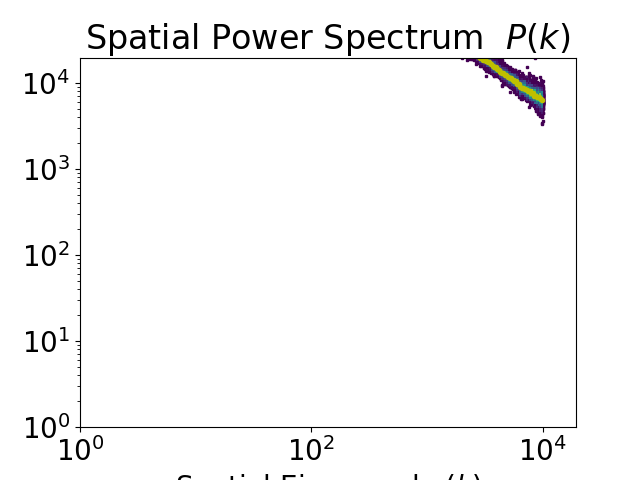

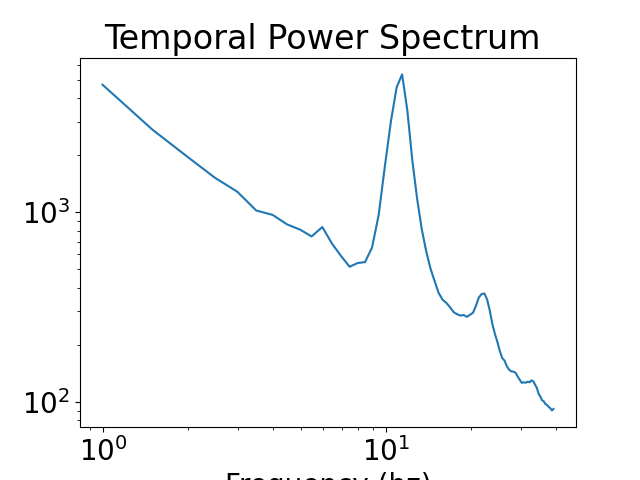

In [7]:

plt.figure()
plt.yscale('log')
plt.xscale('log')
plt.title("Spatial Power Spectrum  $P(k)$")
plt.xlabel("Spatial Eigenmode ($k$)")
#plt.errorbar(x=np.arange(len(empirical_SPS)), y=empirical_SPS, yerr=0, fmt='ks', markersize=1, zorder=1)
plt.errorbar(x=binned_SPS_points, y=binned_SPS, yerr=binned_SPS_err, zorder=2, fmt='yo',markersize=3)

plt.loglog(np.arange(first_k, last_k), empirical_SPS, marker='s', linestyle='', markersize=2, zorder=0, color=[0.267004, 0.004874, 0.329415, 1.])
plot_bins = np.unique(np.logspace(0, np.log10(20000), num=300, dtype=int))[:-1]
y_bins = np.unique(np.logspace(0, np.log10(len(eigenvalues)), num=200, dtype=int))[:-1]
plt.hist2d(np.arange(first_k, last_k), empirical_SPS, (plot_bins, y_bins), cmap='viridis',zorder=1,cmin=2)

fit_to_median=True
if fit_to_median:
    True_Spatial_Spectrum = binned_SPS
    Bins=bins
else:
    True_Spatial_Spectrum = empirical_SPS
    Bins=None
        
LSA=True
Visual=False
SaveFiles=False
FilePath=' '

Min_omega=5*(2*np.pi)
Max_omega=50*(2*np.pi)
Delta_omega=0.1*(2*np.pi)

freqs=np.arange(Min_omega,Max_omega,Delta_omega)/(2*np.pi)

#higher gaussian TPS
higher_gaussian_TPS=100000/(100*freqs+10000)+5*np.exp((-(freqs-10)**2)/(2*0.9**2))
#lower gaussian TPS
lower_gaussian_TPS=100000/(100*freqs+10000)+3*np.exp((-(freqs-10)**2)/(2*1.2**2)) #too complex: 10*(1/(0.1*freqs+0.4)+0.7*np.exp((-(freqs-10)**2)/(2*0.9**2))+0.3*np.exp((-(freqs-22)**2)/(2*3**2)))
#even lower gaussian TPS
even_lower_gaussian_TPS=100000/(100*freqs+10000)+1.5*np.exp((-(freqs-10)**2)/(2*1.8**2))
#lowest gaussian TPS
lowest_gaussian_TPS=100000/(100*freqs+10000)+0.5*np.exp((-(freqs-10)**2)/(2*2.5**2))
#no gaussian TPS
no_gaussian_TPS=100000/(100*freqs+10000)

#new TPS, inspired by ketamine paper. suitable for loglog plotting, so multiplicative factor
new_TPS=2.5*freqs**(-1.25)+1.2*np.exp((-(freqs-10)**2)/(2*0.7**2)) + 0.06*np.exp((-(freqs-20)**2)/(2*0.7**2))
new_TPS[np.where((freqs>20) & (freqs<=40))] = 35*freqs[np.where((freqs>20) & (freqs<=40))]**(-2.17) +0.06*np.exp((-(freqs[np.where((freqs>20) & (freqs<=40))]-20)**2)/(2*0.7**2))
new_TPS[np.where(freqs>40)] = 1.17*freqs[np.where(freqs>40)]**(-1.25)

#empirical TPS from Rikkert MEG data
MEG_PS_data = sp.io.loadmat('/home/aqil/NFModel/MEG_powerspectrum.mat')
freqs = MEG_PS_data['f'][1:][:,0]
empirical_TPS = MEG_PS_data['p'].T[1:][:,0] * 10 **30#28
Min_omega=1*(2*np.pi)
Max_omega=40*(2*np.pi)
Delta_omega=0.5*(2*np.pi)
True_Temporal_Spectrum=np.array(empirical_TPS, dtype='float')#[int(len(new_TPS)*0.1):int(len(new_TPS)*0.5)]
#Max_omega=25*(2*np.pi)


fig2 = plt.figure()
ax = fig2.add_subplot(111)
ax.set_title("Temporal Power Spectrum ")
ax.set_xlabel("Frequency (hz)")
ax.loglog(freqs, True_Temporal_Spectrum)


In [32]:
# ############################
# #single analysis for easy visualization (note that if there are multiple stedy states the visualization will refer to the best one)
# # better_result=dict(x=np.array([1.15357519e+02, 1.80816514e+02, 1.89765888e+02, 2.10306805e+02,
# #        1.43682388e+01, 1.09130331e+00, 5.36635639e+00, 5.31252166e+00,
# #        8.37626732e+00, 2.74681544e+00, 3.66503548e-02, 1.00910684e+02,
# #        4.95497870e+00, 4.47579295e+00]))
# plt.close('all')
# aEE=115
# aIE=175
# aEI=190 
# aII=210
# dE=2.5 
# dI=1 
# P=0 
# Q=0 
# sEE=5.5 
# sIE=3
# sEI=3.5 
# sII=100 
# tE=1.2
# tI=0.8
# initial_guess=np.array([aEE,aIE,aEI,aII,dE,dI,P,Q,sEE,sIE,sEI,sII,tE,tI])

Full_Analysis(better_result['x'], *Args)

array([2.7873e+02, 1.9803e+02, 3.3654e+02, 2.3253e+02, 2.4394e+01,
       5.8765e-01, 6.9643e+00, 9.6387e-01, 2.1967e-03, 7.4568e-03,
       8.4225e-02, 6.4910e+02, 1.6183e-01, 2.0084e-01, 2.7241e-07,
       7.9355e-05, 1.1039e+01, 4.6906e+02, 2.2236e-01, 6.0228e+02,
       4.0177e+02, 4.7740e+02])
Best suitable steady state: 0, with Ess=0.004045 Iss=0.05197.                       
Dist spatial: 200.7, scale params: [ 45831.4567 -83591.5599  53679.5968]                        
Dist temporal: 3431, scale params: [ 6.6353 -2.4167 -8.4358]
                       total dist: 3632


3631.815991302598

In [ ]:
############################
#simple attempt at power spectrum fitting with a minimization algorithm. May get stuck in local minima.
#playing around with tolerance and max number of iterations is often necessary, depending on initial conditions. e.g.
#First run with fairly random initial guess: tol=1e-03, no maxiter (will take a while)
#Run starting from a previously obtained result: tol=1e-08, 'maxiter':2000
#thesis values
result=dict(x=np.array([1.15357519e+02, 1.80816514e+02, 1.89765888e+02, 2.10306805e+02,
       1.43682388e+01, 1.09130331e+00, 5.36635639e+00, 5.31252166e+00,
       1e3*8.37626732e+00, 1e3*2.74681544e+00, 1e3*3.66503548e-02, 1e3*1.00910684e+02,
       4.95497870e+00, 4.47579295e+00]))

In [ ]:
result=dict(x=np.array([6.88112381e+02, 7.85722370e+01, 9.97105458e+02, 1.22114834e+02,
 1.00095980e+02 ,8.71706788e+00 ,4.45444506e+00, 6.72211504e+00,
 2.69548038e-03 ,1.94174600e-03, 1.55065050e-02, 2.22532549e-01,
 7.02896805e-01, 2.03388273e-01]))
result=dict(x=np.array([3.21305207e+02, 1.15229271e+02 ,2.70650624e+02, 1.50968021e+02,
 9.72193535e+01, 2.21122739e-01, 1.40493267e+01, 6.38403082e+00,
 2.84332179e-03, 1.20034605e-02 ,5.54375346e-02, 6.13375039e-02,
 5.39616943e-04, 2.34386738e-05]))
#best linear fit with intercept (also simulated)
result=dict(x=np.array([2.68360960e+02, 1.47992427e+02, 3.40781188e+02, 1.39064758e+02,
 3.91998061e+01 ,1.49887889e+00, 2.16422343e+01, 1.48126196e+01,
 1.80443833e-02, 2.01119682e-03 ,7.65031385e-02 ,3.47241530e-02,
 1.50660781e-01 ,1.30547616e+00]))

result=dict(x=np.array([1.50168054e+02, 2.19398694e+02, 2.60282590e+02, 1.61754514e+02,
 2.66754985e+01 ,1.23424895e+00, 2.22845573e+01, 8.44527415e+00,
 1.61870040e-02, 2.01464558e-03 ,6.87269629e-02, 1.03620878e-01,
 1.90996952e-01 ,2.41407765e-01]))
#final
result=dict(x=np.array([1.48665460e+02, 2.19057310e+02 ,2.62024638e+02 ,1.61437274e+02,
 2.71802361e+01, 1.24033047e+00, 2.23516416e+01 ,8.45022796e+00,
 1.61138979e-02, 2.02249219e-03 ,6.69814861e-02 ,9.14930664e-02,
 2.02440304e-01, 2.34608894e-01]))
#recent
result=dict(x=np.array([1.48430507e+02, 2.19054822e+02, 2.62072488e+02, 1.61171273e+02,
 2.77217907e+01, 7.11917100e-01, 2.27906562e+01, 7.66562110e+00,
 1.37941744e-02, 2.21349125e-03, 6.95808967e-02, 1.42852777e-01,
 3.33701978e-01, 3.79251075e-01]))


In [ ]:
from scipy.optimize import NonlinearConstraint

constraints = []

def spectrum_distance(x):
    E_Spectrum, I_Spectrum = Graph_WC_Spatiotemporal_PowerSpectrum(Laplacian_eigenvalues=eigenvalues, Graph_Kernel=Graph_Kernel, Ess=SStates[0,SSnr], Iss=SStates[1,SSnr],
                                        alpha_EE=x[0], alpha_IE=x[1], alpha_EI=x[2], alpha_II=x[3], d_e=x[4], d_i=x[5], 
                                        sigma_EE=x[8], sigma_IE=x[9], sigma_EI=x[10], sigma_II=x[11],  
                                        D=1, tau_e=x[12], tau_i=x[13],
                                    aDW_EE=x[14],aDW_IE=x[15], aDW_EI=x[16], aDW_II=x[17],
                                    bDW_EE=x[18], bDW_IE=x[19], bDW_EI=x[20], bDW_II=x[21],
                                               
                                        sigma_noise_e=sigma_noise, sigma_noise_i=sigma_noise,
                                        min_omega=Min_omega, max_omega=Max_omega, delta_omega=Delta_omega,
                                        Spatial_Spectrum_Only=False, Visual=False)
    Gw_E=2*np.sum(E_Spectrum,axis=1)
    
    scale_params_temporal = np.array([(True_Temporal_Spectrum.mean())/(Gw_E.mean())])

    current_temporal_spectrum = NF_to_empirical(scale_params_temporal,
                                            Gw_E, Gw_I)
    dist_temporal = np.linalg.norm(np.log10(True_Temporal_Spectrum)-np.log10(current_temporal_spectrum), ord=2)**2

    dist_temporal += np.linalg.norm((np.log10(True_Temporal_Spectrum[1:])-np.log10(True_Temporal_Spectrum[:-1]))-(np.log10(current_temporal_spectrum[1:])-np.log10(current_temporal_spectrum[:-1])), ord=2)**4

    return dist_temporal

constraints.append(NonlinearConstraint(spectrum_distance,
                                                    lb=0,
                                                    ub=1.5))

# Fitting

In [22]:
np.set_printoptions(precision=4)

#dw manual
# result=dict(x=np.array([6.8811e+02, 7.9165e+01, 9.9711e+02, 1.2211e+02, 1.0051e+02, 8.5666e+00,
#  4.3092e+00, 6.9957e+00, 4.6705e-05, 1.4132e-03, 1.8037e-02, 2.3725e-01,
#  4.2467e-01, 3.5548e-01,10**3,10**3,10**3,10**3,10,10,10,10]))
# result=dict(x=np.array([6.88112381e+02, 7.85722370e+01, 9.97105458e+02, 1.22114834e+02,
#  1.00095980e+02 ,8.71706788e+00 ,4.45444506e+00, 6.72211504e+00,
#  2.69548038e-03 ,1.94174600e-03, 1.55065050e-02, 2.22532549e-01,
#  7.02896805e-01, 2.03388273e-01,1e-8,1e-8,1e-8,1e-8,1,1,1,1]))
# #final paper
# result=dict(x=np.array([1.48665460e+02, 2.19057310e+02 ,2.62024638e+02 ,1.61437274e+02,
#  2.71802361e+01, 1.24033047e+00, 2.23516416e+01 ,8.45022796e+00,
#  1.61138979e-02, 2.02249219e-03 ,6.69814861e-02 ,9.14930664e-02,
#  2.02440304e-01, 2.34608894e-01,1e-4,1e-4,1e-4,1e-4,1,1,1,1]))
# result=dict(x=np.array([1.4912e+02, 2.1759e+02, 2.5921e+02, 1.6230e+02, 2.7139e+01, 1.2337e+00,
#  2.2466e+01 ,8.1438e+00, 1.6423e-02 ,2.3137e-03, 6.6802e-02, 9.1542e-02,
#  2.0702e-01 ,2.3107e-01, 5.5491e-07 ,2.8627e-08, 1.4574e-06, 2.2508e-06,
#  1.0028e+00 ,1.0681e+00, 1.0393e+00 ,1.0028e+00]))
#using correlation
# result=dict(x=np.array([1.4868e+02, 2.1904e+02 ,2.6203e+02, 1.6145e+02, 2.7210e+01, 1.3746e+00,
#  2.2464e+01, 8.2988e+00 ,3.8240e-01 ,1.9704e-03, 7.5561e-02 ,9.1635e-02,
#  1.9435e-01, 1.0784e+00 ,9.9111e-01 ,9.9587e-01, 1.0038e+00 ,1.0084e+00,
#  1.0056e-04, 2.9705e-03, 5.1942e-03 ,1.2540e-03]))
#simplified scaling, ord2 distance, new connectome (wave params are *1e5)
# result=dict(x=np.array([5.0412e+02, 7.8384e+01, 1.2358e+03, 1.4698e+02, 4.9484e+01, 7.1233e+00,
#  3.9852e+00 ,3.2349e+00, 2.5905e-03, 1.9210e-03 ,2.9641e-02, 1.8067e-01,
#  8.4580e-01, 1.8146e-01, 9.2182e-05, 1.0270e-04, 1.1615e-04, 1.3291e-04,
#  1.1425e+00 ,1.0105e+00, 8.8928e-01, 8.1291e-01]))
##using temp deriv
# result=dict(x=np.array([7.1585e+02, 3.1227e+02, 2.8629e+02, 1.6478e+02, 2.6326e+01,
#        1.2776e+00, 2.1972e+01, 9.0008e+00, 1.6353e-02, 1.9772e-03,
#        6.8340e-02, 9.3434e-02, 1.9253e-01, 2.3090e-01, 9.7824e-01,
#        8.6755e-01, 1.0670e+00, 9.8824e-01, 5.5653e-04, 4.4763e-06,
#        4.4609e-07, 1.2138e-06]))
#also spatial deriv (temp looks nice) (but spat unstable) 52/12
# result=dict(x=np.array([7.1591e+02, 3.1259e+02, 2.8662e+02, 1.6442e+02, 2.6423e+01,
#        1.2825e+00, 2.1835e+01, 8.7888e+00, 1.7436e-03, 1.0713e-03,
#        7.9180e-02, 1.0382e-01, 1.9880e-01, 2.2459e-01, 9.7932e-01,
#        8.6580e-01, 1.0692e+00, 7.9494e-01, 1.0150e-02, 1.1836e-01,
#        5.4146e-03, 1.0648e-02]))
#spatial deriv stable no peaks
# result=dict(x=(np.array([2.1864e+02, 1.2605e+02, 1.8265e+02, 9.8375e+01, 3.9675e+01,
#        6.3733e-01, 7.3077e+00, 9.4213e-01, 7.1691e-03, 4.1517e-03,
#        8.2703e-02, 9.5257e-02, 2.2306e-01, 1.9062e-01, 3.9409e-08,
#        3.8537e-05, 1.6828e-04, 3.0538e-04, 1.9185e+00, 9.3723e-01,
#        1.7785e+00, 8.9270e-01])))
#manual edits on stable no peaks attempting to get peak without destavlizing
# result=dict(x=(np.array([2.1864e+02, 1.2605e+02, 1.8265e+02, 9.8375e+01, 3.9675e+01,
#        6.3733e-01, 7.3077e+00, 9.4213e-01, 7.1691e-03, 4.1517e-03,
#        8.2703e-02, 9.5257e-02, 2.2306e-01, 1.9062e-01, 9.7932e-01,
#         8.6580e-01, 1.0692e+00, 7.9494e-01, 1.0150e-02, 1.1836e-01,
#         5.4146e-03, 1.0648e-02])))
##DIFF EVO
# result=dict(x=np.array([2.18640000e+02, 1.77321423e+02, 2.97178667e+02, 9.83750000e+01,
#        2.63635016e+01, 6.37330000e-01, 7.30770000e+00, 9.42130000e-01,
#        3.04537982e-03, 4.15170000e-03, 1.06443266e-01, 9.52570000e-02,
#        2.23060000e-01, 1.81494557e-01, 3.94089739e-08, 3.85370000e-05,
#        1.22411168e+02, 3.05380000e-04, 1.91850000e+00, 2.64375950e+00,
#        1.24421530e-06, 8.92700000e-01]))
# #DIFF EVO 2
result=dict(x=np.array([2.41362341e+02, 1.87465571e+02, 3.06359129e+02, 9.83750000e+01,
       2.48031935e+01, 6.37329991e-01, 7.53833099e+00, 9.42130150e-01,
       2.29619993e-03, 4.15156353e-03, 9.20363949e-02, 1.25773356e+01,
       1.67598599e-01, 2.21462762e-01, 6.68549170e-07, 3.77186998e-05,
       3.68790813e+01, 4.29250127e+02, 1.91849997e+00, 1.53394297e-10,
       9.99999995e+02, 2.48366338e+01]))

initial_guess=result['x']#better_result['x']

#initial_guess[14:18] *= 10
#change none to True_Spatial_Spectrum if want to fit to both
Args = (eigenvalues, Graph_Kernel, True_Temporal_Spectrum, Min_omega, Max_omega, Delta_omega,
        True_Spatial_Spectrum, first_k, last_k, Bins, LSA, Visual, SaveFiles, FilePath, 8000, True)


result = sp.optimize.minimize(Full_Analysis, initial_guess, args=Args,
                              method='powell', 
                              bounds=bnds,
                              #constraints=constraints,
                              tol=1e-3,
                              options={#'ftol':1e-10,
                                      # 'xtol':1e-16,
                                     #  'maxiter': 1000,
                                 # 'adaptive':True,
                                   #   'maxls':200,
                                       'disp':True})

Best suitable steady state: 0, with Ess=0.004554 Iss=0.05707.                       
Dist spatial: 8717, scale params: [30461.7385]                        
Dist temporal: 4.875e+06, scale params: [0.2375]
                       total dist: 4.883e+06
Best suitable steady state: 0, with Ess=0.04032 Iss=0.1574.                       
Dist spatial: 6926, scale params: [637177.7516]                        
Dist temporal: 7.563e+05, scale params: [17.5252]
                       total dist: 5.825e+11
Best suitable steady state: 0, with Ess=0.04032 Iss=0.1574.                       
Dist spatial: 6926, scale params: [637177.7516]                        
Dist temporal: 7.563e+05, scale params: [17.5252]
                       total dist: 5.825e+11
Best suitable steady state: 0, with Ess=0.04032 Iss=0.1574.                       
Dist spatial: 6926, scale params: [637177.7516]                        
Dist temporal: 7.563e+05, scale params: [17.5252]
                       total dist: 5.825e+11


Best suitable steady state: 0, with Ess=0.04032 Iss=0.1574.                       
Dist spatial: 6926, scale params: [637177.7516]                        
Dist temporal: 7.563e+05, scale params: [17.5252]
                       total dist: 5.825e+11
Best suitable steady state: 0, with Ess=0.04032 Iss=0.1574.                       
Dist spatial: 6926, scale params: [637177.7516]                        
Dist temporal: 7.563e+05, scale params: [17.5252]
                       total dist: 5.825e+11
Best suitable steady state: 0, with Ess=0.04032 Iss=0.1574.                       
Dist spatial: 6926, scale params: [637177.7516]                        
Dist temporal: 7.563e+05, scale params: [17.5252]
                       total dist: 5.825e+11
Best suitable steady state: 0, with Ess=2.91e-31 Iss=0.04531.                       
Dist spatial: 6926, scale params: [637177.7516]                        
Dist temporal: 7.563e+05, scale params: [17.5252]
                       total dist: 7.632e+0

Best suitable steady state: 0, with Ess=1.151e-12 Iss=0.04531.                       
Dist spatial: 6926, scale params: [637177.1749]                        
Dist temporal: 7.563e+05, scale params: [17.5252]
                       total dist: 7.632e+05
Best suitable steady state: 0, with Ess=1.019e-12 Iss=0.04531.                       
Dist spatial: 6926, scale params: [637177.241]                        
Dist temporal: 7.563e+05, scale params: [17.5252]
                       total dist: 7.632e+05
Best suitable steady state: 0, with Ess=1.083e-12 Iss=0.04531.                       
Dist spatial: 6926, scale params: [637177.209]                        
Dist temporal: 7.563e+05, scale params: [17.5252]
                       total dist: 7.632e+05
Best suitable steady state: 0, with Ess=8.366e-13 Iss=0.04531.                       
Dist spatial: 6926, scale params: [637177.3323]                        
Dist temporal: 7.563e+05, scale params: [17.5252]
                       total dist: 

Best suitable steady state: 0, with Ess=7.748e-31 Iss=0.04531.                       
Dist spatial: 6926, scale params: [637177.7516]                        
Dist temporal: 7.563e+05, scale params: [17.5252]
                       total dist: 7.632e+05
Best suitable steady state: 0, with Ess=3.413e-31 Iss=0.04531.                       
Dist spatial: 6926, scale params: [637177.7516]                        
Dist temporal: 7.563e+05, scale params: [17.5252]
                       total dist: 7.632e+05
Best suitable steady state: 0, with Ess=6.133e-29 Iss=0.04531.                       
Dist spatial: 6926, scale params: [637177.7516]                        
Dist temporal: 7.563e+05, scale params: [17.5252]
                       total dist: 7.632e+05
Best suitable steady state: 0, with Ess=6.366e-30 Iss=0.04531.                       
Dist spatial: 6926, scale params: [637177.7516]                        
Dist temporal: 7.563e+05, scale params: [17.5252]
                       total dist

Best suitable steady state: 0, with Ess=2.095e-06 Iss=8.232e-05.                       
Dist spatial: 7987, scale params: [3064.8936]                        
Dist temporal: 7.346e+04, scale params: [1.5254]
                       total dist: 6.634e+09
Best suitable steady state: 0, with Ess=4.843e-06 Iss=0.0001575.                       
Dist spatial: 2628, scale params: [95197.029]                        
Dist temporal: 1.689e+05, scale params: [7.0334]
                       total dist: 2.942e+10
Best suitable steady state: 1, with Ess=7.742e-06 Iss=0.0008028.                       
Dist spatial: 5808, scale params: [39119.8514]                        
Dist temporal: 2.747e+05, scale params: [13.9118]
                       total dist: 7.866e+10
Best suitable steady state: 0, with Ess=8.208e-06 Iss=0.0002479.                       
Dist spatial: 3960, scale params: [231515.569]                        
Dist temporal: 1.934e+05, scale params: [13.5394]
                       total dist

Best suitable steady state: 0, with Ess=2.629e-11 Iss=5.361e-05.                       
Dist spatial: 6926, scale params: [2.5683e+10]                        
Dist temporal: 1.712e+05, scale params: [2.6709e+09]
                       total dist: 1e+18
Best suitable steady state: 0, with Ess=1.504e-10 Iss=0.000163.                       
Dist spatial: 6930, scale params: [2.5667e+10]                        
Dist temporal: 5.673e+05, scale params: [1.7363e+08]
                       total dist: 1e+18
Best suitable steady state: 0, with Ess=7.57e-11 Iss=0.0001001.                       
Dist spatial: 6927, scale params: [2.568e+10]                        
Dist temporal: 6.772e+05, scale params: [4.9838e+08]
                       total dist: 1e+18
Best suitable steady state: 0, with Ess=1.16e-11 Iss=0.0001016.                       
Dist spatial: 6926, scale params: [2.5688e+10]                        
Dist temporal: 2.595e+06, scale params: [1.937e+10]
                       total dist:

Best suitable steady state: 0, with Ess=9.996e-07 Iss=7.106e-07.                       
Dist spatial: 6926, scale params: [2.568e+10]                        
Dist temporal: 1.565e+06, scale params: [1.7262e+10]
                       total dist: 1e+09
Best suitable steady state: 0, with Ess=9.996e-07 Iss=7.104e-07.                       
Dist spatial: 6926, scale params: [2.568e+10]                        
Dist temporal: 1.565e+06, scale params: [1.7262e+10]
                       total dist: 1e+09
Best suitable steady state: 0, with Ess=9.996e-07 Iss=7.103e-07.                       
Dist spatial: 6926, scale params: [2.568e+10]                        
Dist temporal: 1.565e+06, scale params: [1.7262e+10]
                       total dist: 1e+09
Best suitable steady state: 0, with Ess=9.996e-07 Iss=7.103e-07.                       
Dist spatial: 6926, scale params: [2.568e+10]                        
Dist temporal: 1.565e+06, scale params: [1.7262e+10]
                       total dist

KeyboardInterrupt: 

In [15]:
print(repr(result['x']))

array([3.4621e+02, 1.8845e+02, 3.0684e+02, 8.9834e+01, 2.0778e+01,
       5.9618e-01, 7.2572e+00, 1.0686e+00, 2.2473e-03, 4.6008e-03,
       9.5171e-02, 4.6612e+02, 1.4008e-01, 1.5885e-01, 1.5121e-06,
       1.1534e-04, 7.1909e+01, 5.1649e+02, 3.1845e-01, 5.1997e-01,
       6.8200e+02, 4.7150e+02])


In [ ]:
print(result['x'])

In [ ]:
#dwave starting from paper results (no osc)
print(result['x'])

In [ ]:
#damped wave first manual
print(result['x'])

In [ ]:
#perfect background, no osc peaks
print(result['x'])

In [ ]:
#500 spatial 100 temporal
print(result['x'])

In [ ]:
#no linear intercept. log norm1 **2 +area = 562.1
print(result['x'])

In [ ]:
#no linear intercept. log norm1 **2 +area = 567
print(result['x'])

In [ ]:
#no linear intercept. log norm1 **2 = 240.9 (already very good!) (+areadist =600.5)
print(result['x'])

In [ ]:
#log norm1 **2 + area =   571.9
print(result['x'])

In [ ]:
#log norm1 **2 + area =  570.9
print(result['x'])

In [ ]:
#log norm1 **2 + area =  572.7 (TNC) (see 570 with nelme)
print(result['x'])

In [ ]:
#log norm1 dist 13.92 (352 area)
print(result['x'])

In [ ]:
#log norm1 dist 14.49
print(result['x'])

In [ ]:
#area between curves in log (not loglog) space as objective function. 2norm in log space for scaling (26/01/20)
#1336sp 39te (linear sum, interim best)
#792.2sp 31.7te (product)(excellent for spatial, bad for temporal)
#778sp 30te
#289.5 areas between curv dist, 15.28 log norm1 dist 
print(result['x'])

In [24]:
############################
#more complicated fitting attempt with basinhopping stochastic minimization
#to obtain good results in sensible amounts of time, playing with minimization parameters is required
#the relevant parameter are again tolerance and maxiter, similarly to above (which affect the local minimization loop)
#but also niter and stepsize. these specify how many local minimizations we wish to carry out, 
#and the size of the basin-hopping random step inbetween local minimizations

#best previous spectrum
#new_initial_guess=result['x']

#spectrum (thesis)
#old_initial_guess=np.array([1.15357519e+02, 1.80816514e+02, 1.89765888e+02, 2.10306805e+02,
#       1.43682388e+01, 1.09130331e+00, 5.36635639e+00, 5.31252166e+00,
#       8.37626732e+00, 2.74681544e+00, 3.66503548e-02, 1.00910684e+02,
#       4.95497870e+00, 4.47579295e+00])

#new_initial_guess=np.load('first_spatiotemporal_spectrum_empirical_stps.npy', allow_pickle=True)[()]['x']

#sort of ugly, but need to defind bounds manually for basinhopping
# class MyBounds(object):
#     def __init__(self, xmax=[elem[1] for elem in bnds], xmin=[elem[0] for elem in bnds]):#, hello=this_temporal_distance):
#         self.xmax = np.array(xmax)
#         self.xmin = np.array(xmin)
#         #self.hello = hello
#     def __call__(self, **kwargs):
#         x = kwargs["x_new"]
#         tmax = bool(np.all(x <= self.xmax))
#         tmin = bool(np.all(x >= self.xmin))
#         t=tmax and tmin
        
#         New_Dist=Full_Analysis(x, *Args)
        
#         success = New_Dist<1e6
        
#         #if t and success and New_Dist<self.hello:
#         #    self.hello=New_Dist
#         #    new_initial_guess=np.copy(x)
        
#         return t and success
    
    
    #potential TODO: only accept parameter sets that return stable positive steady states (actually no: they might be locally near a suitable state. still worth to do local minimization)

#minimizer_kwargs={'args':Args, 'method':'TNC', 'bounds':bnds, 'tol':1e-03, 'options':{'maxiter':500}}


# def custom_min(fun, x0, args, **kwargs):
#     Bounds=bnds
#     #Bounds[0:8]=[(elem,elem) for elem in x0[0:8]]
     
     
#     result = sp.optimize.minimize(fun,x0,args=Args, method='Nelder-Mead', bounds=Bounds,
#                                 #tol=1e-16,
#                                 options={'maxiter':2000, 
#                                         # 'ftol': 1e-10,
#                                         #'maxls': 100,
#                                          'disp':True})
#     print(result)
    
#     return result


# better_result = sp.optimize.basinhopping(Full_Analysis, new_initial_guess, niter=1, stepsize=10,
#                                   minimizer_kwargs=dict(method=custom_min),
#                                   accept_test=MyBounds(), disp=True)

#Init=np.stack((new_initial_guess,new_initial_guess,new_initial_guess,new_initial_guess,new_initial_guess))
Init =np.stack((np.array([6.8811e+02, 7.9165e+01, 9.9711e+02, 1.2211e+02, 1.0051e+02, 8.5666e+00,
  4.3092e+00, 6.9957e+00, 4.6705e-05, 1.4132e-03, 1.8037e-02, 2.3725e-01,
  4.2467e-01, 3.5548e-01,10**3,10**3,10**3,10**3,10,10,10,10]),
                np.array([2.1864e+02, 1.2605e+02, 1.8265e+02, 9.8375e+01, 3.9675e+01,
        6.3733e-01, 7.3077e+00, 9.4213e-01, 7.1691e-03, 4.1517e-03,
        8.2703e-02, 9.5257e-02, 2.2306e-01, 1.9062e-01, 3.9409e-08,
        3.8537e-05, 1.6828e-04, 3.0538e-04, 1.9185e+00, 9.3723e-01,
        1.7785e+00, 8.9270e-01]),
                np.array([7.1591e+02, 3.1259e+02, 2.8662e+02, 1.6442e+02, 2.6423e+01,
       1.2825e+00, 2.1835e+01, 8.7888e+00, 1.7436e-03, 1.0713e-03,
       7.9180e-02, 1.0382e-01, 1.9880e-01, 2.2459e-01, 9.7932e-01,
       8.6580e-01, 1.0692e+00, 7.9494e-01, 1.0150e-02, 1.1836e-01,
       5.4146e-03, 1.0648e-02]),
                np.array([2.1864e+02, 1.2605e+02, 1.8265e+02, 9.8375e+01, 3.9675e+01,
        6.3733e-01, 7.3077e+00, 9.4213e-01, 7.1691e-03, 4.1517e-03,
        8.2703e-02, 9.5257e-02, 2.2306e-01, 1.9062e-01, 3.9409e-08,
        3.8537e-05, 1.6828e-04, 3.0538e-04, 1.9185e+00, 9.3723e-01,
        1.7785e+00, 8.9270e-01]),
                np.array([2.18640000e+02, 1.77321423e+02, 2.97178667e+02, 9.83750000e+01,
       2.63635016e+01, 6.37330000e-01, 7.30770000e+00, 9.42130000e-01,
       3.04537982e-03, 4.15170000e-03, 1.06443266e-01, 9.52570000e-02,
       2.23060000e-01, 1.81494557e-01, 3.94089739e-08, 3.85370000e-05,
       1.22411168e+02, 3.05380000e-04, 1.91850000e+00, 2.64375950e+00,
       1.24421530e-06, 8.92700000e-01]),
                np.array([2.41362341e+02, 1.87465571e+02, 3.06359129e+02, 9.83750000e+01,
       2.48031935e+01, 6.37329991e-01, 7.53833099e+00, 9.42130150e-01,
       2.29619993e-03, 4.15156353e-03, 9.20363949e-02, 1.25773356e+01,
       1.67598599e-01, 2.21462762e-01, 6.68549170e-07, 3.77186998e-05,
       3.68790813e+01, 4.29250127e+02, 1.91849997e+00, 1.53394297e-10,
       9.99999995e+02, 2.48366338e+01]),
                np.array([7.1591e+02, 3.1259e+02, 2.8662e+02, 1.6442e+02, 2.6423e+01,
       1.2825e+00, 2.1835e+01, 8.7888e+00, 1.7436e-03, 1.0713e-03,
       7.9180e-02, 1.0382e-01, 1.9880e-01, 2.2459e-01, 9.7932e-01,
       8.6580e-01, 1.0692e+00, 7.9494e-01, 1.0150e-02, 1.1836e-01,
       5.4146e-03, 1.0648e-02]),
                np.array([6.88112381e+02, 7.85722370e+01, 9.97105458e+02, 1.22114834e+02,
  1.00095980e+02 ,8.71706788e+00 ,4.45444506e+00, 6.72211504e+00,
  2.69548038e-03 ,1.94174600e-03, 1.55065050e-02, 2.22532549e-01,
  7.02896805e-01, 2.03388273e-01,1e-8,1e-8,1e-8,1e-8,1,1,1,1]),
               np.array([1.48665460e+02, 2.19057310e+02 ,2.62024638e+02 ,1.61437274e+02,
  2.71802361e+01, 1.24033047e+00, 2.23516416e+01 ,8.45022796e+00,
  1.61138979e-02, 2.02249219e-03 ,6.69814861e-02 ,9.14930664e-02,
  2.02440304e-01, 2.34608894e-01,1e-4,1e-4,1e-4,1e-4,1,1,1,1])
                ,np.array([2.41362341e+02, 1.87465571e+02, 3.06359129e+02, 9.83750000e+01,
       2.48031935e+01, 6.37329991e-01, 7.53833099e+00, 9.42130150e-01,
       2.29619993e-03, 4.15156353e-03, 9.20363949e-02, 1.25773356e+01,
       1.67598599e-01, 2.21462762e-01, 6.68549170e-07, 3.77186998e-05,
       3.68790813e+01, 4.29250127e+02, 1.91849997e+00, 1.53394297e-10,
       9.99999995e+02, 2.48366338e+01]),
                np.array([1.48665460e+02, 2.19057310e+02 ,2.62024638e+02 ,1.61437274e+02,
  2.71802361e+01, 1.24033047e+00, 2.23516416e+01 ,8.45022796e+00,
  1.61138979e-02, 2.02249219e-03 ,6.69814861e-02 ,9.14930664e-02,
  2.02440304e-01, 2.34608894e-01,1,1,1,1,0,0,0,0]),
                np.array([1.48665460e+02, 2.19057310e+02 ,2.62024638e+02 ,1.61437274e+02,
  2.71802361e+01, 1.24033047e+00, 2.23516416e+01 ,8.45022796e+00,
  1.61138979e-02, 2.02249219e-03 ,6.69814861e-02 ,9.14930664e-02,
  2.02440304e-01, 2.34608894e-01,1,1,1,1,0,0,0,0]),
               np.array([2.41362341e+02, 1.87465571e+02, 3.07070611e+02, 9.83020065e+01,
       2.50482813e+01, 6.42417383e-01, 7.53833099e+00, 9.42130411e-01,
       2.29472860e-03, 4.38074525e-03, 9.66418938e-02, 1.25773356e+01,
       1.67598599e-01, 2.20469165e-01, 6.90292552e-07, 3.77694684e-05,
       3.52815567e+01, 4.28978324e+02, 1.90121591e+00, 1.53420388e-10,
       9.99999995e+02, 2.48366338e+01]),
               np.array([2.41362341e+02, 1.91972736e+02, 3.43129169e+02, 9.81822854e+01,
       1.83207981e+01, 6.81612724e-01, 7.53902321e+00, 9.42131958e-01,
       2.27827826e-03, 4.54506746e-03, 9.91236679e-02, 1.25773356e+01,
       1.67598599e-01, 1.95175950e-01, 9.02941281e-07, 3.89303902e-05,
       3.47269915e+01, 4.28930846e+02, 1.32830186e+00, 1.53420388e-10,
       9.98838348e+02, 2.57433636e+01]),
               np.array([2.41362341e+02, 1.91972736e+02, 3.43129169e+02, 9.81822854e+01,
       1.83207981e+01, 6.81612724e-01, 7.53902321e+00, 9.42131958e-01,
       2.27827826e-03, 4.54506746e-03, 9.91236679e-02, 1.25773356e+01,
       1.67598599e-01, 1.95175950e-01, 9.02941281e-07, 3.89303902e-05,
       3.47269915e+01, 4.28930846e+02, 1.32830186e+00, 1.53420388e-10,
       9.98838348e+02, 2.57433636e+01]),
               np.array([2.31433810e+02, 1.90466280e+02, 3.65867090e+02, 9.83488441e+01,
       1.57541270e+01, 1.06325753e+00, 6.83325920e+00, 9.42128706e-01,
       1.92504060e-03, 4.24971198e-03, 9.36492001e-02, 1.25773356e+01,
       1.48446722e-01, 3.28173163e-01, 1.71043587e-06, 1.02027693e-04,
       1.47802800e+02, 4.28158241e+02, 6.11200743e-02, 4.06048066e-01,
       9.73777791e+02, 2.74980421e+01]),
               np.array([2.31539428e+02, 1.90466280e+02, 3.66655721e+02, 9.83556269e+01,
       1.57541270e+01, 1.06415552e+00, 6.83325920e+00, 9.42043599e-01,
       1.92504060e-03, 4.24870488e-03, 9.36492001e-02, 1.25773356e+01,
       1.48446722e-01, 3.27362408e-01, 1.71043587e-06, 1.03542890e-04,
       1.48506875e+02, 4.28158241e+02, 8.34346063e-02, 1.53420388e-10,
       5.86913552e+02, 2.77827962e+01]),np.load('de_fitting_5_subc_dti50.npy'),
               np.load('de_fitting_7_subc_dti50.npy'),
               np.array([3.4504e+02, 1.8893e+02, 3.0881e+02, 9.0579e+01, 2.0876e+01,
       5.8554e-01, 7.2718e+00, 9.4413e-01, 2.2475e-03, 4.6180e-03,
       9.5867e-02, 4.4390e+02, 1.4111e-01, 1.5644e-01, 1.4847e-06,
       9.7867e-05, 7.2554e+01, 6.0210e+02, 3.2340e-01, 7.2727e-03,
       6.0175e+02, 2.7397e+02]),
               np.load('de_fitting_8_subc_dti50.npy'),
               np.load('de_fitting_1_subc_dti1.npy'),
               np.load('fitting_nosubc_dti1_1.npy')))

disp_print = False
Args = (eigenvalues, Graph_Kernel, True_Temporal_Spectrum, Min_omega, Max_omega, Delta_omega,
        True_Spatial_Spectrum, first_k, last_k, Bins, LSA, Visual, SaveFiles, FilePath, 20, disp_print)

Init_mult = np.tile(Init,(3,1))
Init_mult[:,8:12] *= 1e3
#Init='sobol' (bad)
#try with default strategy (doing)
#try higher 0.8 (doing 0.5)
#currently trying with full dti, subcortex, dti factor of 50 instead of 200
#allow intercept in linear scaling?
#change metric back to area between curves?
#allow combination with inhibitory spectrum

better_result = sp.optimize.differential_evolution(Full_Analysis, bounds=bnds, 
                                                 args=Args, tol=1e-6, disp=True, init=Init_mult,
                                                 maxiter=20000, polish=False, workers=15, recombination=0.5,
                                                # strategy='best1exp',
                                                mutation=(0.1,1.9))


/home/aqil/.conda/envs/py310/lib/python3.10/site-packages/scipy/_lib/deprecation.py:20: RuntimeWarning: overflow encountered in exp
  return fun(*args, **kwargs)
/home/aqil/git/Graph-Stochastic-Wilson-Cowan-Model/core/analysis.py:40: RuntimeWarning: invalid value encountered in multiply
  Damped_Wave_Kernel=(r_1*sp.exp(r_2*t)-r_2*sp.exp(r_1*t))/(r_1-r_2)
/home/aqil/git/Graph-Stochastic-Wilson-Cowan-Model/core/analysis.py:40: RuntimeWarning: invalid value encountered in divide
  Damped_Wave_Kernel=(r_1*sp.exp(r_2*t)-r_2*sp.exp(r_1*t))/(r_1-r_2)
/home/aqil/git/Graph-Stochastic-Wilson-Cowan-Model/core/analysis.py:41: RuntimeWarning: invalid value encountered in divide
  Damped_Wave_Kernel_prime=(sp.exp(r_1*t)-sp.exp(r_2*t))/(r_1-r_2)


differential_evolution step 1: f(x)= 60913.5
differential_evolution step 2: f(x)= 23877.8


/home/aqil/.conda/envs/py310/lib/python3.10/site-packages/scipy/_lib/deprecation.py:20: RuntimeWarning: overflow encountered in exp
  return fun(*args, **kwargs)
/home/aqil/git/Graph-Stochastic-Wilson-Cowan-Model/core/analysis.py:40: RuntimeWarning: invalid value encountered in multiply
  Damped_Wave_Kernel=(r_1*sp.exp(r_2*t)-r_2*sp.exp(r_1*t))/(r_1-r_2)
/home/aqil/git/Graph-Stochastic-Wilson-Cowan-Model/core/analysis.py:40: RuntimeWarning: invalid value encountered in divide
  Damped_Wave_Kernel=(r_1*sp.exp(r_2*t)-r_2*sp.exp(r_1*t))/(r_1-r_2)
/home/aqil/git/Graph-Stochastic-Wilson-Cowan-Model/core/analysis.py:41: RuntimeWarning: invalid value encountered in divide
  Damped_Wave_Kernel_prime=(sp.exp(r_1*t)-sp.exp(r_2*t))/(r_1-r_2)


differential_evolution step 3: f(x)= 23877.8
differential_evolution step 4: f(x)= 23877.8


/home/aqil/.conda/envs/py310/lib/python3.10/site-packages/scipy/_lib/deprecation.py:20: RuntimeWarning: overflow encountered in exp
  return fun(*args, **kwargs)
/home/aqil/git/Graph-Stochastic-Wilson-Cowan-Model/core/analysis.py:40: RuntimeWarning: invalid value encountered in multiply
  Damped_Wave_Kernel=(r_1*sp.exp(r_2*t)-r_2*sp.exp(r_1*t))/(r_1-r_2)
/home/aqil/git/Graph-Stochastic-Wilson-Cowan-Model/core/analysis.py:40: RuntimeWarning: invalid value encountered in divide
  Damped_Wave_Kernel=(r_1*sp.exp(r_2*t)-r_2*sp.exp(r_1*t))/(r_1-r_2)
/home/aqil/git/Graph-Stochastic-Wilson-Cowan-Model/core/analysis.py:41: RuntimeWarning: invalid value encountered in divide
  Damped_Wave_Kernel_prime=(sp.exp(r_1*t)-sp.exp(r_2*t))/(r_1-r_2)
/home/aqil/.conda/envs/py310/lib/python3.10/site-packages/scipy/_lib/deprecation.py:20: RuntimeWarning: overflow encountered in exp
  return fun(*args, **kwargs)
/home/aqil/git/Graph-Stochastic-Wilson-Cowan-Model/core/analysis.py:40: RuntimeWarning: invalid v

differential_evolution step 5: f(x)= 23877.8


/home/aqil/.conda/envs/py310/lib/python3.10/site-packages/scipy/_lib/deprecation.py:20: RuntimeWarning: overflow encountered in exp
  return fun(*args, **kwargs)
/home/aqil/git/Graph-Stochastic-Wilson-Cowan-Model/core/analysis.py:40: RuntimeWarning: invalid value encountered in multiply
  Damped_Wave_Kernel=(r_1*sp.exp(r_2*t)-r_2*sp.exp(r_1*t))/(r_1-r_2)
/home/aqil/git/Graph-Stochastic-Wilson-Cowan-Model/core/analysis.py:40: RuntimeWarning: invalid value encountered in divide
  Damped_Wave_Kernel=(r_1*sp.exp(r_2*t)-r_2*sp.exp(r_1*t))/(r_1-r_2)
/home/aqil/git/Graph-Stochastic-Wilson-Cowan-Model/core/analysis.py:41: RuntimeWarning: invalid value encountered in divide
  Damped_Wave_Kernel_prime=(sp.exp(r_1*t)-sp.exp(r_2*t))/(r_1-r_2)


differential_evolution step 6: f(x)= 23877.8
differential_evolution step 7: f(x)= 23877.8
differential_evolution step 8: f(x)= 23877.8
differential_evolution step 9: f(x)= 23877.8
differential_evolution step 10: f(x)= 23877.8
differential_evolution step 11: f(x)= 23877.8
differential_evolution step 12: f(x)= 23877.8
differential_evolution step 13: f(x)= 23877.8
differential_evolution step 14: f(x)= 23877.8
differential_evolution step 15: f(x)= 23877.8
differential_evolution step 16: f(x)= 23877.8


/home/aqil/.conda/envs/py310/lib/python3.10/site-packages/scipy/_lib/deprecation.py:20: RuntimeWarning: overflow encountered in exp
  return fun(*args, **kwargs)
/home/aqil/git/Graph-Stochastic-Wilson-Cowan-Model/core/analysis.py:40: RuntimeWarning: invalid value encountered in multiply
  Damped_Wave_Kernel=(r_1*sp.exp(r_2*t)-r_2*sp.exp(r_1*t))/(r_1-r_2)
/home/aqil/git/Graph-Stochastic-Wilson-Cowan-Model/core/analysis.py:40: RuntimeWarning: invalid value encountered in divide
  Damped_Wave_Kernel=(r_1*sp.exp(r_2*t)-r_2*sp.exp(r_1*t))/(r_1-r_2)
/home/aqil/git/Graph-Stochastic-Wilson-Cowan-Model/core/analysis.py:41: RuntimeWarning: invalid value encountered in divide
  Damped_Wave_Kernel_prime=(sp.exp(r_1*t)-sp.exp(r_2*t))/(r_1-r_2)


differential_evolution step 17: f(x)= 23877.8
differential_evolution step 18: f(x)= 23877.8
differential_evolution step 19: f(x)= 23877.8
differential_evolution step 20: f(x)= 23877.8
differential_evolution step 21: f(x)= 23877.8
differential_evolution step 22: f(x)= 23877.8
differential_evolution step 23: f(x)= 23877.8
differential_evolution step 24: f(x)= 23877.8
differential_evolution step 25: f(x)= 23877.8
differential_evolution step 26: f(x)= 23877.8
differential_evolution step 27: f(x)= 23877.8
differential_evolution step 28: f(x)= 23877.8
differential_evolution step 29: f(x)= 23877.8
differential_evolution step 30: f(x)= 23877.8
differential_evolution step 31: f(x)= 23877.8
differential_evolution step 32: f(x)= 23877.8
differential_evolution step 33: f(x)= 23877.8
differential_evolution step 34: f(x)= 23877.8
differential_evolution step 35: f(x)= 23877.8
differential_evolution step 36: f(x)= 23877.8
differential_evolution step 37: f(x)= 23877.8
differential_evolution step 38: f(

/home/aqil/.conda/envs/py310/lib/python3.10/site-packages/scipy/_lib/deprecation.py:20: RuntimeWarning: overflow encountered in exp
  return fun(*args, **kwargs)
/home/aqil/git/Graph-Stochastic-Wilson-Cowan-Model/core/analysis.py:40: RuntimeWarning: invalid value encountered in multiply
  Damped_Wave_Kernel=(r_1*sp.exp(r_2*t)-r_2*sp.exp(r_1*t))/(r_1-r_2)
/home/aqil/git/Graph-Stochastic-Wilson-Cowan-Model/core/analysis.py:40: RuntimeWarning: invalid value encountered in divide
  Damped_Wave_Kernel=(r_1*sp.exp(r_2*t)-r_2*sp.exp(r_1*t))/(r_1-r_2)
/home/aqil/git/Graph-Stochastic-Wilson-Cowan-Model/core/analysis.py:41: RuntimeWarning: invalid value encountered in divide
  Damped_Wave_Kernel_prime=(sp.exp(r_1*t)-sp.exp(r_2*t))/(r_1-r_2)


differential_evolution step 80: f(x)= 23877.8
differential_evolution step 81: f(x)= 23877.8
differential_evolution step 82: f(x)= 23877.8
differential_evolution step 83: f(x)= 23877.8
differential_evolution step 84: f(x)= 23877.8
differential_evolution step 85: f(x)= 23877.8
differential_evolution step 86: f(x)= 23877.8


Process ForkPoolWorker-171:
Process ForkPoolWorker-173:


KeyboardInterrupt: 

In [ ]:
np.save('de_fitting_2_subc_dti1.npy', better_result['x'])

In [21]:
print(repr(better_result['x']))

array([2.7873e+02, 1.9803e+02, 3.3654e+02, 2.3253e+02, 2.4394e+01,
       5.8765e-01, 6.9643e+00, 9.6387e-01, 2.1967e-03, 7.4568e-03,
       8.4225e-02, 6.4910e+02, 1.6183e-01, 2.0084e-01, 2.7241e-07,
       7.9355e-05, 1.1039e+01, 4.6906e+02, 2.2236e-01, 6.0228e+02,
       4.0177e+02, 4.7740e+02])


In [10]:
#
better_result=dict(x=np.load('de_fitting_1_subc_dti1.npy'))

# Replot fit results

Damped Wave
[3.46216604e+02 1.88444468e+02 3.06836114e+02 8.98396567e+01
 2.07731507e+01 5.96256688e-01 7.25806820e+00 9.44125260e-01
 2.24753624e-03 4.60138520e-03 9.51828433e-02 4.66116705e+02
 1.40094006e-01 1.58870828e-01 1.51230921e-06 1.15352140e-04
 7.19090494e+01 5.16496231e+02 3.18491183e-01 5.20037600e-01
 6.81998494e+02 4.71502518e+02]
[[0.00320081]
 [0.05841576]]


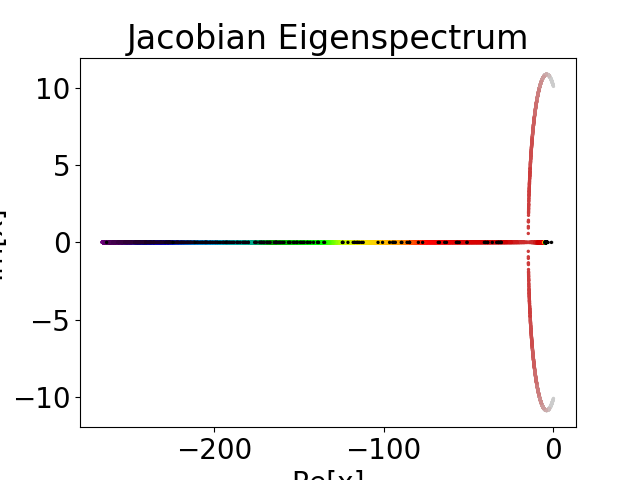

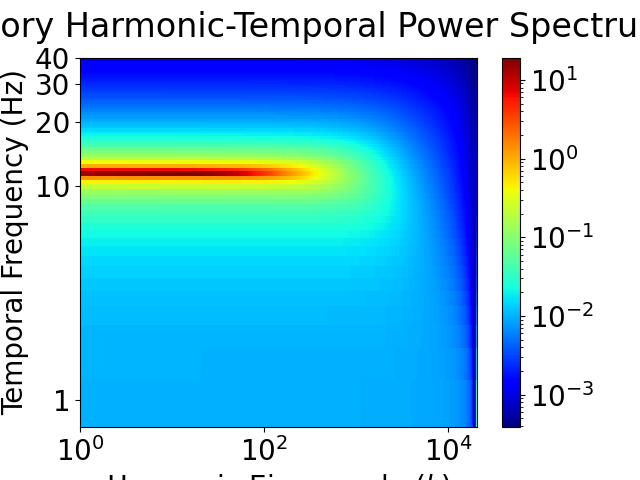

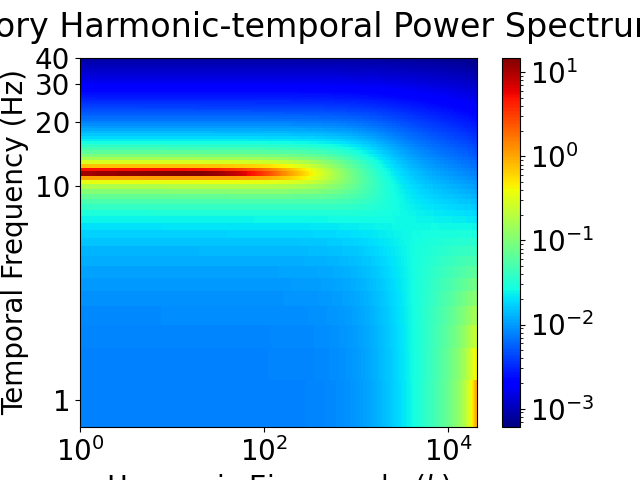

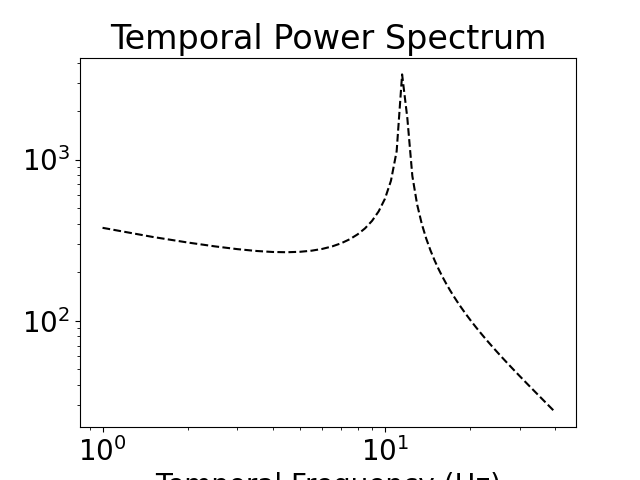

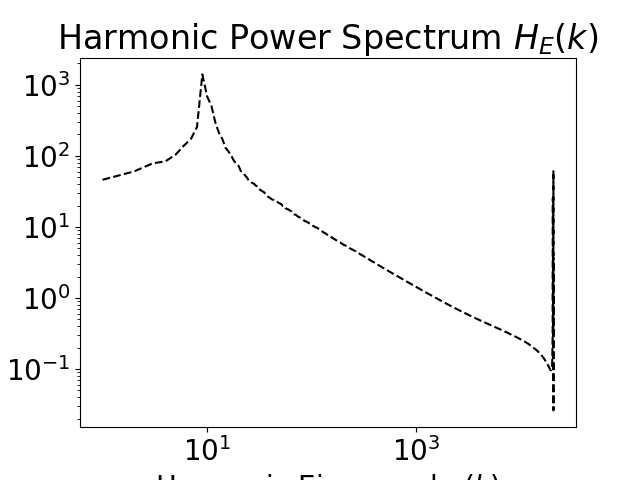

No such comm: 406c6f406d694488818567216ad3c0eb
No such comm: 406c6f406d694488818567216ad3c0eb


In [8]:
#re-analyze result of minimization procedure

#thesis parameters
#better_result=dict(x=np.array([1.15357519e+02, 1.80816514e+02, 1.89765888e+02, 2.10306805e+02,
#       1.43682388e+01, 1.09130331e+00, 5.36635639e+00, 5.31252166e+00,
#       8.37626732e+00, 2.74681544e+00, 3.66503548e-02, 1.00910684e+02,
#       4.95497870e+00, 4.47579295e+00]))

#better_result=np.load('decent_spatiotemporal_spectrum.npy', allow_pickle=True)[()]
#better_result=np.load('decent_spatiotemporal_spectrum_lower_gauss.npy', allow_pickle=True)[()]
#better_result=np.load('decent_spatiotemporal_spectrum_even_lower_gauss.npy', allow_pickle=True)[()]
#better_result=np.load('decent_spatiotemporal_spectrum_lowest_gauss.npy', allow_pickle=True)[()]
#better_result=np.load('decent_spatiotemporal_spectrum_lower_gauss_no_spatial_peak.npy', allow_pickle=True)[()]

#IMPORTANT: if using spectra above, run the line below, since they were not done in metres
#better_result['x'][8:12]/=1000

#better_result=np.load('decent_spatiotemporal_spectrum_first_new_realistic_metres.npy', allow_pickle=True)[()]
#better_result=np.load('spatiotemporal_spectrum_empirical_tps.npy', allow_pickle=True)[()]
#better_result=np.load('spatiotemporal_spectrum_empirical_sps.npy', allow_pickle=True)[()]
#better_result=np.load('first_spatiotemporal_spectrum_empirical_stps.npy', allow_pickle=True)[()]

#better_result = np.load('stps_empirical_loglog_median_fitting.npy', allow_pickle=True)[()]
# #final paper
# result=dict(x=np.array([1.48665460e+02, 2.19057310e+02,2.62024638e+02 ,1.61437274e+02,
#  2.71802361e+01, 1.24033047e+00, 2.23516416e+01 ,8.45022796e+00,
#  1.61138979e-02, 2.02249219e-03 ,6.69814861e-02 ,9.14930664e-02,
#  2.02440304e-01, 2.34608894e-01, 1,1,1,1,0,0,0,0]))
# result=dict(x=np.array([1.4867e+02, 2.1906e+02, 2.6202e+02, 1.6144e+02, 2.7185e+01,
#        1.2499e+00, 2.2367e+01, 8.4248e+00, 1.6367e-01, 1.5367e-01,
#        5.8512e-01, 4.2050e-02, 2.9954e-01, 3.8242e-01, 1.0134e+00,
#        1.0133e+00, 1.0782e+00, 1.0243e+00, 1.5275e-01, 1.5259e-01,
#        1.5267e-01, 1.5259e-01]))
# result=dict(x=np.array([7.1638e+02, 3.1264e+02, 2.8691e+02, 1.6440e+02, 2.6439e+01,
#        1.2847e+00, 2.1833e+01, 8.7844e+00, 1.7472e-03, 1.0749e-03,
#        7.9154e-02, 1.0383e-01, 1.9918e-01, 2.2551e-01, 9.8274e-01,
#        8.6826e-01, 1.0781e+00, 7.9521e-01, 1.0032e-02, 1.1822e-01,
#        5.4294e-03, 1.0669e-02]))

result=dict(x=np.load('de_fitting_8_subc_dti50.npy'))
#result=dict(x=np.load('de_fitting_1_subc_dti1.npy'))
#result=dict(x=np.load('fitting_nosubc_dti1_1.npy'))


better_result = result

# if Graph_Kernel != 'Damped Wave' and len(better_result['x'])<16:
#     better_result['x'] = np.concatenate((better_result['x'],[0,0,0,0,1,1,1,1]))
    
print(Graph_Kernel)    
print(better_result['x'])    

SStates, success = H_Simple_Steady_State(alpha_EE=better_result['x'][0], alpha_IE=better_result['x'][1], alpha_EI=better_result['x'][2], alpha_II=better_result['x'][3], 
                                         d_e=better_result['x'][4], d_i=better_result['x'][5], P=better_result['x'][6], Q=better_result['x'][7])
print(SStates)       

SSnr=0
sigma_noise=1#0.0000001

SStype, found_suitable, JacEigs = GraphWC_Jacobian_TrDet(Laplacian_eigenvalues=eigenvalues, Graph_Kernel=Graph_Kernel, Ess=SStates[0,SSnr], Iss=SStates[1,SSnr],
                                     alpha_EE=better_result['x'][0], alpha_IE=better_result['x'][1], alpha_EI=better_result['x'][2], alpha_II=better_result['x'][3], d_e=better_result['x'][4], d_i=better_result['x'][5], 
                                     sigma_EE=better_result['x'][8], sigma_IE=better_result['x'][9], sigma_EI=better_result['x'][10], sigma_II=better_result['x'][11],  
                                     D=1, tau_e=better_result['x'][12], tau_i=better_result['x'][13], 
                                    aDW_EE=better_result['x'][14],aDW_IE=better_result['x'][15], aDW_EI=better_result['x'][16], aDW_II=better_result['x'][17],
                                    bDW_EE=better_result['x'][18], bDW_IE=better_result['x'][19], bDW_EI=better_result['x'][20], bDW_II=better_result['x'][21],
                                                         
                                                         Visual=True)    


E_Spectrum, I_Spectrum = Graph_WC_Spatiotemporal_PowerSpectrum(Laplacian_eigenvalues=eigenvalues, Graph_Kernel=Graph_Kernel, Ess=SStates[0,SSnr], Iss=SStates[1,SSnr],
                                        alpha_EE=better_result['x'][0], alpha_IE=better_result['x'][1], alpha_EI=better_result['x'][2], alpha_II=better_result['x'][3], d_e=better_result['x'][4], d_i=better_result['x'][5], 
                                        sigma_EE=better_result['x'][8], sigma_IE=better_result['x'][9], sigma_EI=better_result['x'][10], sigma_II=better_result['x'][11],  
                                        D=1, tau_e=better_result['x'][12], tau_i=better_result['x'][13],
                                    aDW_EE=better_result['x'][14],aDW_IE=better_result['x'][15], aDW_EI=better_result['x'][16], aDW_II=better_result['x'][17],
                                    bDW_EE=better_result['x'][18], bDW_IE=better_result['x'][19], bDW_EI=better_result['x'][20], bDW_II=better_result['x'][21],
                                               
                                        sigma_noise_e=sigma_noise, sigma_noise_i=sigma_noise,
                                        min_omega=Min_omega, max_omega=Max_omega, delta_omega=Delta_omega,
                                        Spatial_Spectrum_Only=False, Visual=True)

Spectrum_spatial_only = Graph_WC_Spatiotemporal_PowerSpectrum(Laplacian_eigenvalues=eigenvalues, Graph_Kernel=Graph_Kernel, Ess=SStates[0,SSnr], Iss=SStates[1,SSnr],
                                        alpha_EE=better_result['x'][0], alpha_IE=better_result['x'][1], alpha_EI=better_result['x'][2], alpha_II=better_result['x'][3], d_e=better_result['x'][4], d_i=better_result['x'][5], 
                                        sigma_EE=better_result['x'][8], sigma_IE=better_result['x'][9], sigma_EI=better_result['x'][10], sigma_II=better_result['x'][11],  
                                        D=1, tau_e=better_result['x'][12], tau_i=better_result['x'][13],
                                    aDW_EE=better_result['x'][14],aDW_IE=better_result['x'][15], aDW_EI=better_result['x'][16], aDW_II=better_result['x'][17],
                                    bDW_EE=better_result['x'][18], bDW_IE=better_result['x'][19], bDW_EI=better_result['x'][20], bDW_II=better_result['x'][21],
                                               
                                        sigma_noise_e=sigma_noise, sigma_noise_i=sigma_noise,
                                        min_omega=Min_omega, max_omega=Max_omega, delta_omega=Delta_omega,
                                        Spatial_Spectrum_Only=True, Visual=True)



spatial scale factors: [ 41618.77178016 -52199.4635543   48376.47844369]
spatial distance: 1444.241278818734
KstestResult(statistic=0.6377293692672019, pvalue=1.4121687842617868e-84, statistic_location=28817.941108580246, statistic_sign=1)
KstestResult(statistic=0.17889908256880735, pvalue=0.0018264525924454149, statistic_location=61324.8075449804, statistic_sign=-1)
temporal scale factor: [ 1.6173709   0.32164795 48.37142782]
temporal distance: 7040.881810105443
[[1.0 0.9222486071845162]
 [0.9222486071845162 1.0]]
[[1.0 0.33620857895605777]
 [0.33620857895605777 1.0]]
KstestResult(statistic=0.1282051282051282, pvalue=0.5459989251653901, statistic_location=834.878059387987, statistic_sign=1)
[3.46216604e+02 1.88444468e+02 3.06836114e+02 8.98396567e+01
 2.07731507e+01 5.96256688e-01 7.25806820e+00 9.44125260e-01
 2.24753624e-03 4.60138520e-03 9.51828433e-02 4.66116705e+02
 1.40094006e-01 1.58870828e-01 1.51230921e-06 1.15352140e-04
 7.19090494e+01 5.16496231e+02 3.18491183e-01 5.2003760

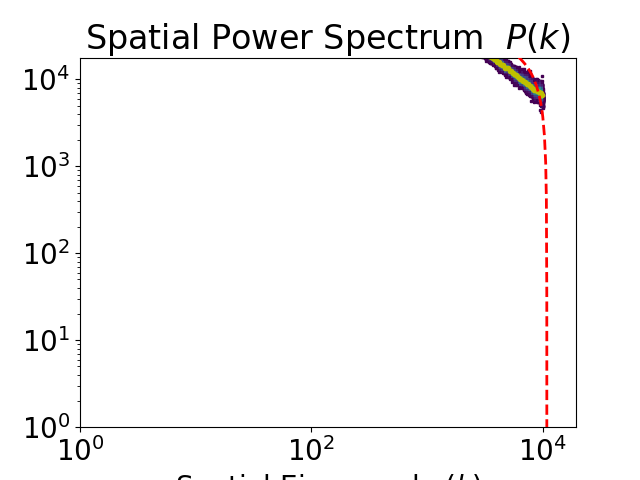

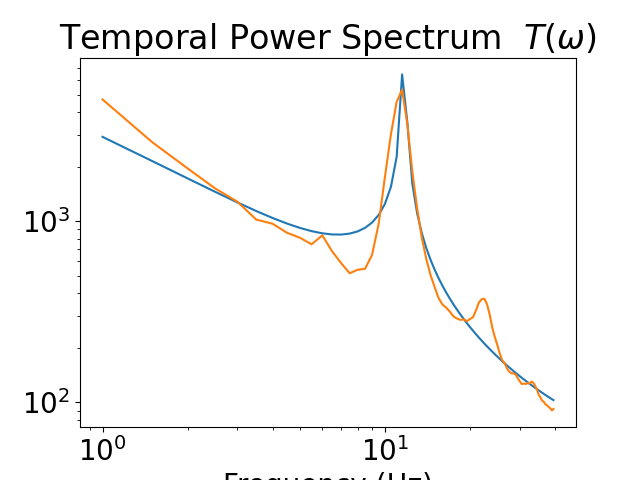

In [9]:
#import seaborn as sns
#from analysis import find_scaling, NF_to_empirical
Gk_E=Spectrum_spatial_only[:,0,0] #Delta_omega*np.sum(Spectrum,axis=0)/np.pi
Gk_I=Spectrum_spatial_only[:,1,1]
Gw_E=2*np.sum(E_Spectrum,axis=1)
Gw_I=2*np.sum(I_Spectrum,axis=1)
plt.ion()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Spatial Power Spectrum  $P(k)$")
ax.set_xlabel("Spatial Eigenmode ($k$)")

if not fit_to_median:
    E_spatial_spectrum = Gk_E
    I_spatial_spectrum = Gk_I
    SPS_points = np.arange(first_k,last_k)
else:
    E_spatial_spectrum = np.array([np.median(elem) for elem in np.array_split(Gk_E[first_k:last_k], bins)])
    I_spatial_spectrum = np.array([np.median(elem) for elem in np.array_split(Gk_I[first_k:last_k], bins)])
    SPS_points = np.array([elem.mean() for elem in np.array_split(np.arange(first_k,last_k), bins)])

    
# a_matrix_spatial = np.vstack((E_spatial_spectrum,
#                               I_spatial_spectrum,
#                            #   E_spatial_spectrum*I_spatial_spectrum,
#                               np.ones_like(True_Spatial_Spectrum))).T

#scale_params_spatial = np.linalg.lstsq(a_matrix_spatial, True_Spatial_Spectrum)[0]    
scale_params_spatial = sp.optimize.fmin(find_scaling, x0=[1,0,0], xtol=1e-10,args=(E_spatial_spectrum,I_spatial_spectrum,True_Spatial_Spectrum), disp=0)

#scale_params_spatial = np.array([(True_Spatial_Spectrum.mean())/(E_spatial_spectrum.mean())])

# n_spatial = len(True_Spatial_Spectrum)    
# a_spatial = (n_spatial*np.dot(E_spatial_spectrum,True_Spatial_Spectrum)-np.sum(True_Spatial_Spectrum)*np.sum(E_spatial_spectrum))/(n_spatial*np.dot(E_spatial_spectrum,E_spatial_spectrum)-np.sum(E_spatial_spectrum)**2)
# b_spatial = (np.sum(True_Spatial_Spectrum)-a_spatial*np.sum(E_spatial_spectrum))/n_spatial
# scale_params_spatial = np.array([a_spatial,b_spatial])

current_spatial_spectrum = NF_to_empirical(scale_params_spatial,
                                           E_spatial_spectrum,
                                           I_spatial_spectrum)

#to avoid log10 throwing tantrums. but of course no "good" spectrum should have negative values                    
current_spatial_spectrum[current_spatial_spectrum<=0] = 1e-10

data_1=np.vstack((SPS_points, np.log10(True_Spatial_Spectrum))).T
data_2=np.vstack((SPS_points, np.log10(current_spatial_spectrum))).T   

dist_spatial = (1+sm.area_between_two_curves(data_1,data_2))**1

#np.linalg.norm(np.log10(True_Spatial_Spectrum) - np.log10(current_spatial_spectrum), ord=1)#sm.area_between_two_curves(data_1,data_2)#np.linalg.norm((np.log10(True_Spatial_Spectrum) - np.log10(current_spatial_spectrum), ord=1)#np.linalg.norm(True_Spatial_Spectrum - a_spatial*current_spatial_spectrum-b_spatial, ord=2)#1-sp.stats.ks_2samp(True_Spatial_Spectrum, current_spatial_spectrum*a_spatial+b_spatial)[1]#1-np.ma.corrcoef(True_Spatial_Spectrum, current_spatial_spectrum)[0,1]#

dist_spatial += (1+np.linalg.norm(np.log10(True_Spatial_Spectrum)-np.log10(current_spatial_spectrum), ord=2))**2

dist_spatial += (1+np.linalg.norm((np.log10(True_Spatial_Spectrum[1:])-np.log10(True_Spatial_Spectrum[:-1]))-(np.log10(current_spatial_spectrum[1:])-np.log10(current_spatial_spectrum[:-1])), ord=2))**2

print("spatial scale factors: {}".format(scale_params_spatial))
print("spatial distance: {}".format(dist_spatial))

ax.loglog(np.arange(first_k, last_k), empirical_SPS, marker='s', linestyle='', markersize=2, zorder=0, color=[0.267004, 0.004874, 0.329415, 1.])
plot_bins = np.unique(np.logspace(0, np.log10(20000), num=300, dtype=int))[:-1]
y_bins = np.unique(np.logspace(0, np.log10(18715), num=200, dtype=int))[:-1]
ax.hist2d(np.arange(first_k, last_k), empirical_SPS, (plot_bins, y_bins), cmap='viridis',zorder=1,cmin=2)

ax.loglog(np.arange(len(eigenvalues)),  NF_to_empirical(scale_params_spatial,Gk_E,Gk_I), zorder=3,color='red', linestyle='--', linewidth=2)
plt.errorbar(x=binned_SPS_points, y=binned_SPS, yerr=binned_SPS_err, zorder=2, fmt='yo-',markersize=3)

print(sp.stats.ks_2samp(empirical_SPS,  current_spatial_spectrum))
print(sp.stats.ks_2samp(True_Spatial_Spectrum, current_spatial_spectrum))
      
fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_title("Temporal Power Spectrum  $T(\omega)$")
ax.set_xlabel("Frequency (Hz)")

freqs=np.arange(Min_omega,Max_omega,Delta_omega)

# a_matrix_temporal = np.vstack((Gw_E,
#                                Gw_I,
#                               # Gw_E*Gw_I,
#                                np.ones_like(True_Temporal_Spectrum))).T

# scale_params_temporal = np.linalg.lstsq(a_matrix_temporal, True_Temporal_Spectrum)[0]
scale_params_temporal = sp.optimize.fmin(find_scaling, x0=[1,0,0], xtol=1e-10, args=(Gw_E,Gw_I,True_Temporal_Spectrum), disp=0)

#scale_params_temporal = np.array([(True_Temporal_Spectrum.mean())/(Gw_E.mean())])

current_temporal_spectrum = NF_to_empirical(scale_params_temporal,
                                            Gw_E, Gw_I)

#to avoid log10 throwing tantrums. but of course no "good" spectrum should have negative values
#current_temporal_spectrum[current_temporal_spectrum<=0] = 1e-10

data_3=np.vstack((np.arange(Min_omega,Max_omega,Delta_omega),np.log10(True_Temporal_Spectrum))).T
data_4=np.vstack((np.arange(Min_omega,Max_omega,Delta_omega),np.log10(current_temporal_spectrum))).T        
dist_temporal = (1+sm.area_between_two_curves(data_3,data_4))**3#np.linalg.norm(np.log10(True_Temporal_Spectrum) - np.log10(current_temporal_spectrum), ord=1)#sm.area_between_two_curves(data_3,data_4)#np.linalg.norm(True_Temporal_Spectrum - current_temporal_spectrum, ord=1)##np.linalg.norm(True_Temporal_Spectrum - a_temporal*current_temporal_spectrum-b_temporal, ord=2)#1-sp.stats.ks_2samp(True_Temporal_Spectrum, current_temporal_spectrum*a_temporal+b_temporal)[1]#1-np.ma.corrcoef(True_Temporal_Spectrum, current_temporal_spectrum)[0,1]#
dist_temporal += (1+np.linalg.norm(np.log10(True_Temporal_Spectrum)-np.log10(current_temporal_spectrum), ord=2))**3

dist_temporal += (1+np.linalg.norm((np.log10(True_Temporal_Spectrum[1:])-np.log10(True_Temporal_Spectrum[:-1]))-(np.log10(current_temporal_spectrum[1:])-np.log10(current_temporal_spectrum[:-1])), ord=2))**3

print("temporal scale factor: {}".format(scale_params_temporal))
print("temporal distance: {}".format(dist_temporal))

print(np.ma.corrcoef(True_Temporal_Spectrum, current_temporal_spectrum))
print(np.ma.corrcoef(True_Spatial_Spectrum, current_spatial_spectrum))


print(sp.stats.ks_2samp(True_Temporal_Spectrum, current_temporal_spectrum))

ax.loglog(freqs/(2*np.pi),
            current_temporal_spectrum)
ax.loglog(freqs/(2*np.pi), 
            True_Temporal_Spectrum)

#np.save('decent_spatiotemporal_spectrum.npy', better_result)
print(better_result['x'])


In [ ]:
#np.load('decent_spatiotemporal_spectrum_lower_gauss.npy')[()]['x']-better_result['x']
#current best (loglog space fitting)
[ 1.06682212e+03,  1.73415339e+02,  2.92699896e+03,  2.95074005e+02,
  9.07838853e+01,  3.19257788e+00,  7.47262994e+00, -1.76660214e-02,
  5.43684383e-04, -1.75210509e-09,  5.52478781e-04,  5.40207870e+04,
  9.29655089e+00,  3.27876977e-01]
#logspace excellent s2.16 t0.86 (kstat pval 0.21 0.68)
better_result['x'] [ 1.60298254e+03,  1.84931805e+02,  2.99551387e+03,  2.80138120e+02,
  9.29297308e+01,  1.22714483e+00,  7.24240357e+00,  3.71750330e-01,
  4.34632128e-04,  2.05916610e-05,  6.11898211e-04, -3.38503489e+10,
  6.93229886e+00,  1.51916190e-01]
#np.save('stps_empirical_first_loglog_median_fitting.npy', better_result)
[6.32352428e+02, 7.93766496e+01, 3.47535746e+02, 1.07039076e+02,
       1.56586247e+02, 4.22226636e+00, 1.54479298e+01, 2.49662094e+01,
       4.31042051e-02, 2.44534241e-03, 4.77988694e-02, 5.17697376e-02,
       1.37486268e-01, 6.30906093e-01])

better_result['x']=[ 1.06682212e+03,  1.73415339e+02,  2.92699896e+03,  2.95074005e+02,
  9.07838853e+01,  3.19257788e+00,  7.47262994e+00, -1.76660214e-02,
  5.43684383e-04, -1.75210509e-09,  5.52478781e-04,  5.40207870e+04,
  9.29655089e+00,  3.27876977e-01]

In [ ]:
#np.save('stps_empirical_loglog_median_fitting.npy', better_result)

In [ ]:
#comparison of numerical (nonlinear) simulations and (linearized) semi analytic results 
#(any parameter set; grid laplacian only):
#
#1) test for steady state calculation: simulate (with no noise) on a grid, start directly from SS solution.
#2) test for stability/instability/oscillations: add noise in the grid simulation for specific parameter sets
#3) test for power spectrum calculation: run noisy grid simulation and compare prediction with measured PS (see handwritten notes)
#
################################################################################################
#testing the correctness of the parameter fit procedure(full analysis + minimization algorithm) result
#(intended mainly for the better_result parameter set)
#
#retest minimization algorithm, with objective the current best-fit PS obtained and random initial condition. see if other parameter combinations give the same, ideally converge to same par. set
#
#check (via effect on linearized Jk eigenvalues) if a nearby hopf bifurcation can be induced by changing P or some other parameter 
#(to ask rikkert: do we want this as a prior requirement in minimization? would be hard but doable)
#

# simulations

In [ ]:
#1D predictions
#set up 1D-specific simulation parameters and WCM propagators
one_dim=True
syn=10
#if making plot from connectome minimization, need to change this value to the number of connectome nodes
gridsize=1000#len(eigenvalues)
h=0.001
#Min_omega=5*(2*np.pi)
#Max_omega=50*(2*np.pi)
#Delta_omega=0.1*(2*np.pi)

Graph_Kernel='Damped Wave'
one_dim_eigenvalues, one_dim_eigenvectors = one_dim_Laplacian_eigenvalues(gridsize, h, syn, vecs=True)
#one_dim_eigenvalues2 = one_dim_Laplacian_eigenvalues(gridsize, h, syn)

#re-analyze result of minimization procedure
#better_result=np.load('decent_spatiotemporal_spectrum.npy')[()]

#better_result=np.load('decent_spatiotemporal_spectrum_lower_gauss.npy')[()]

#better_result=np.load('decent_spatiotemporal_spectrum_even_lower_gauss.npy')[()]

#better_result=np.load('decent_spatiotemporal_spectrum_lowest_gauss.npy')[()]

#thesis result
#better_result=dict(x=np.array([1.15357519e+02, 1.80816514e+02, 1.89765888e+02, 2.10306805e+02,
#       1.43682388e+01, 1.09130331e+00, 5.36635639e+00, 5.31252166e+00,
#       8.37626732e+00, 2.74681544e+00, 3.66503548e-02, 1.00910684e+02,
#       4.95497870e+00, 4.47579295e+00]))

#better_result=dict(x=np.array([1.15357519e+02, 1.80816514e+02, 1.89765888e+02, 2.10306805e+02,
#       1.43682388e+01, 1.09130331e+00, 5.36635639e+00, 5.31252166e+00,
#       8.37626732e+00, 2.74681544e+00, 3.66503548e-02, 1.00910684e+02,
#       4.95497870e+00, 4.47579295e+00]))f

aEE=better_result['x'][0]
aIE=better_result['x'][1]
aEI=better_result['x'][2]
aII=better_result['x'][3]
dE=better_result['x'][4]
dI=better_result['x'][5]
P=better_result['x'][6]
Q=better_result['x'][7]
sEE=better_result['x'][8]
sIE=better_result['x'][9]
sEI=better_result['x'][10]
sII=better_result['x'][11]
D=1
tE=better_result['x'][12]
tI=better_result['x'][13]
aDWEE=better_result['x'][14]
aDWIE=better_result['x'][15]
aDWEI=better_result['x'][16]
aDWII=better_result['x'][17]
bDWEE=better_result['x'][18]
bDWIE=better_result['x'][19]
bDWEI=better_result['x'][20]
bDWII=better_result['x'][21]

snE=0.0000001
#snE=0.0001
snI=snE

#given parameters, calculate steady states
steady_states, success = H_Simple_Steady_State(aEE, aIE, aEI, aII, dE, dI, P, Q)


#for each steady state, compute linear stability and power spectrum
if success==True:
    nrSS=len(steady_states[0])
    allG = np.empty((nrSS,int((Max_omega-Min_omega)/Delta_omega),gridsize), dtype=float)
    allGI = np.empty((nrSS,int((Max_omega-Min_omega)/Delta_omega),gridsize), dtype=float)
    SStypes=np.zeros(nrSS)
    for ss in range(nrSS):

        Ess = steady_states[0,ss]
        Iss = steady_states[1,ss]

        SStypes[ss], found_suitable, JacEigs = GraphWC_Jacobian_TrDet(one_dim_eigenvalues, Graph_Kernel, Ess, Iss,
                                         alpha_EE=aEE, alpha_IE=aIE, alpha_EI=aEI, alpha_II=aII, d_e=dE, d_i=dI,
                                         sigma_EE=sEE, sigma_IE=sIE, sigma_EI=sEI, sigma_II=sII, D=D, 
                                         tau_e=tE, tau_i=tI,
                                                                      
                                    aDW_EE=aDWEE,aDW_IE=aDWIE, aDW_EI=aDWEI, aDW_II=aDWII,
                                    bDW_EE=bDWEE, bDW_IE=bDWIE, bDW_EI=bDWEI, bDW_II=bDWII,
                                               Visual=True) 

        #allG[ss,:,:] = 
        allG[ss,:,:], allGI[ss,:,:] =Graph_WC_Spatiotemporal_PowerSpectrum(one_dim_eigenvalues, Graph_Kernel, Ess, Iss,
                                                aEE, aIE, aEI, aII, dE, dI,
                                                 sEE, sIE, sEI, sII, D, 
                                                 tE, tI,
                                                
                                    aDWEE,aDWIE, aDWEI, aDWII,
                                    bDWEE, bDWIE, bDWEI, bDWII,        
                                                 snE, snI, 
                                                  Min_omega, Max_omega, Delta_omega,          
                                                   Spatial_Spectrum_Only=False, Visual=True)
        
        sspectrum =Graph_WC_Spatiotemporal_PowerSpectrum(one_dim_eigenvalues, Graph_Kernel, Ess, Iss,
                                                aEE, aIE, aEI, aII, dE, dI,
                                                 sEE, sIE, sEI, sII, D, 
                                                 tE, tI,
                                                         
                                    aDWEE,aDWIE, aDWEI, aDWII,
                                    bDWEE, bDWIE, bDWEI, bDWII,   
                                                 snE, snI,         
                                                   Spatial_Spectrum_Only=True, Visual=True)
        

        
        Func_Conn_prediction = Functional_Connectivity(one_dim_eigenvectors, sspectrum[:,0,0], Visual=True)
        

        

In [ ]:
#1D grid simulation (nonlinear wilson-cowan)
#thesis values
#Time=100
#Delta_t=0.01

#more recent param set values
#Time=3
#Delta_t=0.0001

#duration and timestep (empirical loglog median fitting)
Time=10
Delta_t=0.00005

#duration and timestep (empirical spatial only linear scaling)
Time=50
Delta_t=0.0005

#parameters of 1D graph (nonlocal synapses, grid size, grid spacing)
#syn=150
#gridsize=1000
#h=1

nrSS=0
Ess = steady_states[0,nrSS]
Iss = steady_states[1,nrSS]    


E_total = Graph_Wilson_Cowan_Model(Ess, Iss, Time, Delta_t,                          
                         aEE, aIE, aEI, aII,
                         sEE, sIE, sEI, sII, D,
                         dE, dI, P, Q, tE, tI, 
                                    aDWEE,aDWIE, aDWEI, aDWII,
                                    bDWEE, bDWIE, bDWEI, bDWII,             
                        snE, snI, Graph_Kernel,                                  
                         one_dim=True, syn=syn, gridsize=gridsize, h=h,
                         Visual=True, SaveActivity=False, Filepath=' ')   


In [ ]:
#activity analysis and comparison with prediction
#thesis values
#Max_omega=50
#Delta_omega=0.1

#Min_omega=1*(2*np.pi)
#Max_omega=100*(2*np.pi)
plt.close('all')
PS, TPS, FC = Activity_Analysis(Ess, Iss, Delta_t, 
                            aEE, aIE, aEI, aII,
                            sEE, sIE, sEI, sII, D,
                            dE, dI, P, Q, tE, tI, snE, snI, Graph_Kernel,                             
                            beta=False, E_total=E_total,                                                      
                            prediction=True, min_omega=Min_omega, max_omega=Max_omega, delta_omega=Delta_omega,                        
                            one_dim=True, syn=syn, gridsize=gridsize, h=h,                           
                            Visual=True, Save_Results=False, Filepath=' ')


In [ ]:
#Human connectome simulation (linearized wilson-cowan: perturbation about steady state)
#thesis time and timestep values
#Time=100
#Delta_t=0.01
#more recent work
Time=2
Delta_t=0.0001

#final (empirical)
Time=100
Delta_t=0.0001

nrSS=0
Ess = steady_states[0,nrSS]
Iss = steady_states[1,nrSS]  
SPS_sims=[]
TPS_sims=[]
for sims in range(3):
    Beta_E_total = Linearized_GLDomain_Wilson_Cowan_Model(Ess, Iss, Time, Delta_t,                          
                         aEE, aIE, aEI, aII,
                         sEE, sIE, sEI, sII, D,
                         dE, dI, P, Q, tE, tI, 
                                    aDWEE,aDWIE, aDWEI, aDWII,
                                    bDWEE, bDWIE, bDWEI, bDWII,                                                            
                        snE, snI, Graph_Kernel,
                         one_dim=False, eigvals=eigenvalues, eigvecs=None,
                         Visual=False, SaveActivity=False, Filepath=' ') 

    PS_full, TPS_full = Activity_Analysis(Ess, Iss, Delta_t,
                                   aEE, aIE, aEI, aII,
                                   sEE, sIE, sEI, sII, D,
                                   dE, dI, P, Q, tE, tI, 
                                          
                                    aDWEE,aDWIE, aDWEI, aDWII,
                                    bDWEE, bDWIE, bDWEI, bDWII,  
                                          
                                    snE, snI, Graph_Kernel,
                                
                                   beta=True, beta_E_total=Beta_E_total,
                                   
                                   prediction=True, min_omega=Min_omega, max_omega=Max_omega, delta_omega=Delta_omega,
                                      
                                 #  Spatial_scaling=[a_spatial,b_spatial], Temporal_scaling=[a_temporal,b_temporal],
                                   
                                   one_dim=False, syn=syn, gridsize=gridsize, h=h,
                                      
                                   eigvals=eigenvalues, eigvecs=None,
                                   
                                   Visual=True, Save_Results=False, Filepath=' ')
    
    SPS_sims.append(PS_full)
    TPS_sims.append(TPS_full)
    #np.save('/home/aqil/NFModel/Beta_E_total_fix'+str(sims), Beta_E_total)
    del Beta_E_total


In [ ]:
SPS_sims=[]
Time=100
Delta_t=0.0001

nrSS=0
Ess = steady_states[0,nrSS]
Iss = steady_states[1,nrSS]  
for sims in range(3):
    Beta_E_total = np.load('/home/aqil/NFModel/Beta_E_total'+str(sims)+'.npy')

    PS_full, TPS_full = Activity_Analysis(Ess, Iss, Delta_t,
                                   aEE, aIE, aEI, aII,
                                   sEE, sIE, sEI, sII, D,
                                   dE, dI, P, Q, tE, tI, snE, snI, Graph_Kernel,
                                
                                   beta=True, beta_E_total=Beta_E_total,
                                   
                                   prediction=True, min_omega=Min_omega, max_omega=Max_omega, delta_omega=Delta_omega,
                                      
                                 #  Spatial_scaling=[a_spatial,b_spatial], Temporal_scaling=[a_temporal,b_temporal],
                                   
                                   one_dim=False, syn=syn, gridsize=gridsize, h=h,
                                      
                                   eigvals=eigenvalues, eigvecs=None,
                                   
                                   Visual=True, Save_Results=False, Filepath=' ')    

    
    SPS_sims.append(PS_full)

    del Beta_E_total    
    
PS_full = np.median(SPS_sims, axis=0)

In [ ]:
np.save('/home/aqil/NFModel/simulations_median_PS.npy', PS_full)

In [ ]:
plt.close('all')
plt.ion()
plt.figure()

PS_sims_rescaled = NF_to_empirical(scale_params_spatial,PS_full,0)[first_k:last_k]
analytic_PS_rescaled = NF_to_empirical(scale_params_spatial,Gk_E,Gk_I)[first_k:last_k]

binned_SPS_sim = np.array([np.median(elem) for elem in np.array_split(PS_sims_rescaled, bins)])
binned_SPS_err_sim = np.array([sp.stats.sem(elem) for elem in np.array_split(PS_sims_rescaled, bins)])

plt.loglog(np.arange(first_k, last_k),PS_sims_rescaled, marker='s', linestyle='', markersize=2, zorder=1, color=[0.267004, 0.004874, 0.329415, 1.], label='Simulation PS')
plt.hist2d(np.arange(first_k, last_k),PS_sims_rescaled,(plot_bins, y_bins), cmap='viridis',zorder=2,cmin=2)
plt.loglog(np.arange(first_k, last_k), analytic_PS_rescaled, zorder=4,color='black', linestyle='--', linewidth=2, label = 'Predicted PS')
plt.errorbar(x=binned_SPS_points, y=binned_SPS_sim, yerr=binned_SPS_err_sim, zorder=3, fmt='ro-',markersize=3, label='Simulation binned median PS')
plt.legend(prop={'size': 12})

plt.figure()

plt.loglog(np.arange(first_k, last_k), empirical_SPS, marker='s', linestyle='', markersize=2, zorder=0, color=[0.267004, 0.004874, 0.329415, 1.], label='fMRI PS')
plt.hist2d(np.arange(first_k, last_k), empirical_SPS, (plot_bins, y_bins), cmap='viridis',zorder=1,cmin=2)
plt.loglog(np.arange(first_k, last_k), analytic_PS_rescaled, zorder=3,color='black', linestyle='--', linewidth=2, label = 'Predicted PS')
plt.errorbar(x=binned_SPS_points, y=binned_SPS, yerr=binned_SPS_err, zorder=2, fmt='yo-',markersize=3, label='fMRI binned median PS')
plt.legend(prop={'size': 12})

In [ ]:
plt.figure()
plt.loglog(np.arange(first_k, last_k), analytic_PS_rescaled, zorder=2,color='black', linestyle='--', linewidth=3, label = 'Prediction', alpha=0.65)
plt.errorbar(x=binned_SPS_points, y=binned_SPS_sim, yerr=0, fmt='ro-',markersize=4, label='Simulation',zorder=1, alpha=0.65)
plt.errorbar(x=binned_SPS_points, y=binned_SPS, yerr=0, fmt='co-',markersize=4.5, label='Resting-state fMRI', zorder=0)
plt.xlabel("Spatial Eigenmode ($k$)")
plt.ylabel("Power ($P(k)$)")
plt.legend(prop={'size': 18}, loc=3)

In [ ]:
#covariance = np.cov(timecourse)
covariance[covariance==0] = 1e-10
covariance[covariance==1] = 1e-10

plt.figure()
plt.pcolormesh(np.dot(np.diag(np.power(np.diag(covariance),-0.5)),np.dot(covariance,np.diag(np.power(np.diag(covariance),-0.5)))),
              vmin=-1,
              vmax=1)

In [ ]:
Func_Conn_prediction = Functional_Connectivity(eigenvectors, NF_to_empirical(scale_params_spatial,Gk_E,Gk_I), one_dim=False, Visual=True)

In [ ]:
##########################################################################################################
0.0001 10 slightly too high (time interval not small enough)
0.00008 8 slightly too high (time interval not small enough?)
0.00005 10 not doable
0.00005 7 slightly too low
0.00005 5 slightly too low (duration too short?)
0.00001 1 white noise like (low) (duration too short)

In [ ]:
#further verification: 1D grid simulation (linearized wilson-cowan: perturbation about steady state)

#duration and timestep
Time=3
Delta_t=0.00001

#parameters of 1D graph (nonlocal synapses, grid size, grid spacing)
syn=150
gridsize=1000
h=1

nrSS=0
Ess = steady_states[0,nrSS]
Iss = steady_states[1,nrSS]   



Beta_E_total_1D = Linearized_GLDomain_Wilson_Cowan_Model(Ess, Iss, Time, Delta_t,                          
                         aEE, aIE, aEI, aII,
                         sEE, sIE, sEI, sII, D,
                         dE, dI, P, Q, tE, tI, snE, snI, Graph_Kernel,
                         one_dim=True, syn=syn, gridsize=gridsize, h=h,
                         eigvals=None, eigvecs=None,
                         Visual=False, SaveActivity=False, Filepath=' ') 



In [ ]:
#activity analysis of linearized model and comparison with prediction (perturbation about steady state)
#thesis values
#Max_omega=50
#Delta_omega=0.1
plt.close('all')
Max_omega=3000
Delta_omega=0.5

PS_full_1D, TPS_full_1D = Activity_Analysis(Ess, Iss, Delta_t,
                                   aEE, aIE, aEI, aII,
                                   sEE, sIE, sEI, sII, D,
                                   dE, dI, P, Q, tE, tI, snE, snI, Graph_Kernel,
                                
                                   beta=True, beta_E_total=Beta_E_total_1D,
                                   
                                   prediction=True, max_omega=Max_omega, delta_omega=Delta_omega,
                                   
                                   one_dim=True, syn=syn, gridsize=gridsize, h=h,
                                      
                                   eigvals=None, eigvecs=None,
                                   
                                   Visual=True, Save_Results=False, Filepath=' ')


In [ ]:
#MISC
#Beta_E_total=np.load('G:/Macbook Stuff/Simulation Results/Decent spatiotemporal spectrum activity.npy')
#del Beta_E_total
#del eigenvectors
#del connectome_activity
#np.save('G:/Macbook Stuff/Simulation Results/Decent spatiotemporal spectrum activity.npy', Beta_E_total)
#print(len(Beta_E_total[0]))
#print(Beta_E_total[0])
with h5py.File("G:/Macbook Stuff/Simulation Results/Decent spatiotemporal spectrum activity.h5") as hf:
    if "Activity" not in list(hf.keys()):
        #connectome_activity=np.dot(eigenvectors,Beta_E_total)
        hf.create_dataset("Activity",  data=connectome_activity)
    else:
        print("Warning: overwriting results of a previous simulation.") 

In [ ]:
#nonlinear connectome simulation
nrSS=0
Ess = steady_states[0,nrSS]
Iss = steady_states[1,nrSS]    
Time=100
Delta_t=0.0001

E_total = Graph_Wilson_Cowan_Model(Ess, Iss, Time, Delta_t,                          
                         aEE, aIE, aEI, aII,
                         sEE, sIE, sEI, sII, D,
                         dE, dI, P, Q, tE, tI, snE, snI, Graph_Kernel,                                  
                         one_dim=False, eigvals=eigenvalues, eigvecs=eigenvectors,
                         Visual=False, SaveActivity=False, Filepath=' ')  

In [ ]:
PS_full, TPS_full = Activity_Analysis(Ess, Iss, Delta_t,
                                   aEE, aIE, aEI, aII,
                                   sEE, sIE, sEI, sII, D,
                                   dE, dI, P, Q, tE, tI, snE, snI, Graph_Kernel,
                                
                                   E_total=E_total,
                                   
                                   prediction=True, max_omega=Max_omega, delta_omega=Delta_omega,
                                   
                                   one_dim=False, syn=syn, gridsize=gridsize, h=h,
                                      
                                   eigvals=eigenvalues, eigvecs=eigenvectors,
                                   
                                   Visual=True, Save_Results=False, Filepath=' ')

In [ ]:
np.save('/home/aqil/NFModel/nonlsim_fix_TPS.npy', TPS_full)

In [ ]:
from scipy.stats import gamma
def hrf(times):
    """ Return values for HRF at given times """
    # Gamma pdf for the peak
    peak_values = gamma.pdf(times, 6)
    # Gamma pdf for the undershoot
    undershoot_values = gamma.pdf(times, 12)
    # Combine them
    values = peak_values - 0.35 * undershoot_values
    # Scale max to 0.6
    return values / np.max(values)

hrf_times = np.arange(0, 25, 0.0001)
hrf_signal=100*hrf(hrf_times)
print(hrf_signal.reshape(1,-1).shape)
plt.figure()
plt.plot(hrf_signal)

In [ ]:
#not working?
E_total_fMRI = sp.signal.fftconvolve(E_total-E_total.mean(1)[...,np.newaxis], hrf_signal.reshape(1,-1), mode='same', axes=(-1))[...,::10000]

In [ ]:
plt.figure()
#plt.plot(100*E_total[0])
plt.plot(sp.signal.fftconvolve((E_total[0]-E_total[0].mean()), hrf_signal, mode='same'))

In [ ]:
FC_nonlinear_sim = np.corrcoef(E_total[:,:10000])

In [ ]:
FC_nonlinear_sim_fmri = np.corrcoef(E_total_fMRI)

In [ ]:
#np.save('/home/aqil/NFModel/nonlsim_fc_fmri.npy', FC_nonlinear_sim_fmri)
#E_total = np.load('/home/aqil/NFModel/nonlsim_act.npy')
np.save('/home/aqil/NFModel/nonlsim_act_fix.npy',E_total)

In [ ]:
plt.close('all')
plt.figure(figsize=(10,10))
plt.ylim(3700,1200)
plt.xlim(5500,7500)
#plt.ylim(10000,9000)
#plt.xlim(11000,12000)
plt.imshow(FC_nonlinear_sim, vmin=0, vmax=0.075, cmap='inferno')

plt.colorbar()

In [ ]:
#################******** PROPAGATOR TESTS ********#################

In [ ]:
#propagator test 1
#damped wave/telegrapher parameters
#params for first working tests: a=0.3, b=0.001, c=0, Delta_t=1, h=1 (worked with 2-normalized eigenvalues)
#make a smaller: wave travels faster
a=0.3
#make b larger: more diffusion
b=0.001
#nonzero c: switch from damped wave to telegrapher eqn
c=0

gridsize=1000
syn=0
h=1
u_0=0.3*sp.signal.gaussian(gridsize, 10)#np.zeros(gridsize)#(-0.1/499**2)*(np.arange(gridsize)-499)**2 + 0.1 
Delta_t=1
Time=100
#u_0[499]=1
u_final=graph_propagator_test(u_0, Time, Delta_t, kernel_param=Delta_t, Graph_Kernel='Damped Wave', a=a, b=b, c=c, sigma_noise=0.0,
                          one_dim=True, syn=syn, gridsize=gridsize,  h=h, eigvals=None, eigvecs=None,                         
                          Visual=True, SaveActivity=False, Filepath=' ', NSim=0)

1000.0
0
1000.0000000001872


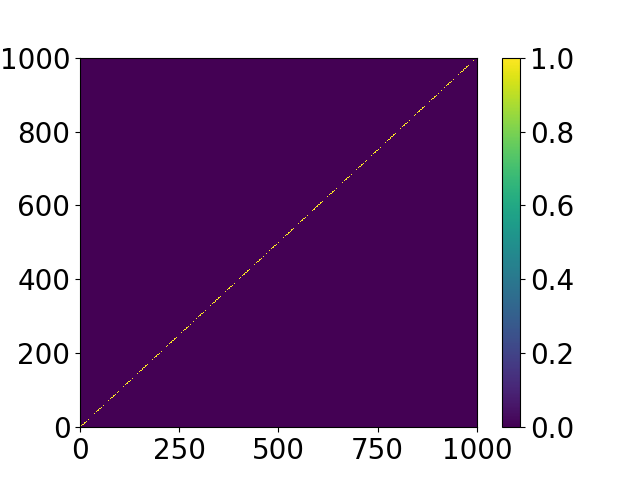

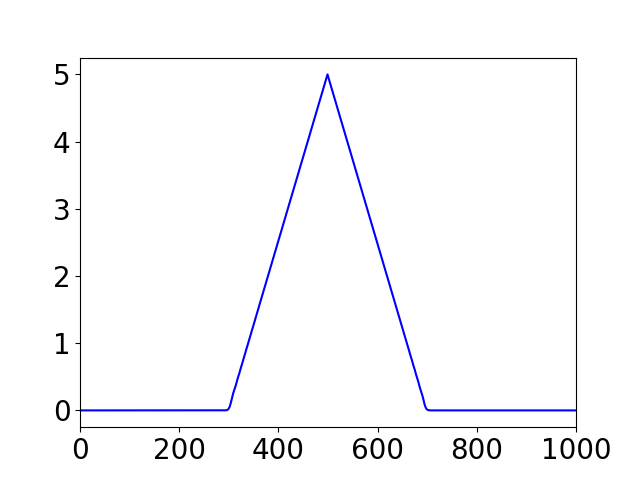

In [35]:
#propagator test 2
gridsize=1000
syn=0
h=1
u_0=np.zeros(gridsize)#(-0.1/499**2)*(np.arange(gridsize)-499)**2 + 0.1 
Delta_t=0.005
Time=Delta_t
u_0[499]=1000
#u_0=np.ones(gridsize)
print(np.sum(u_0))
u_final=graph_propagator_test(u_0, Time, Delta_t, kernel_param=Delta_t, Graph_Kernel='Pyramid', sigma_noise=0,
                          one_dim=True, syn=syn, gridsize=gridsize,  h=h, eigvals=None, eigvecs=None,                         
                          Visual=True, SaveActivity=False, Filepath=' ', NSim=0)
print(np.sum(u_final))

In [ ]:
#proptest 3 cortical mesh convolutions

u_0=np.zeros(len(eigenvalues))#np.zeros(gridsize)#(-0.1/499**2)*(np.arange(gridsize)-499)**2 + 0.1 
u_0[6369]=50
u_prop=graph_propagator_test(u_0, Time=50, Delta_t=50, kernel_param=50/1000000, Graph_Kernel='Gaussian', sigma_noise=0.0,
                          one_dim=False, syn=0, gridsize=0,  h=0, eigvals=eigenvalues, eigvecs=eigenvectors,                         
                          Visual=False, SaveActivity=False, Filepath=' ', NSim=0)

In [ ]:
#propagator test 4: cortical mesh
##NOTE: THESE PARAMETERS WERE FOR THE EIGENVALUES OF THE LAPLACIAN IN MILLIMIETERS
#damped wave/telegrapher parameters
#params for first working tests: a=0.3, b=0.001, c=0, Delta_t=1
#params for wave first figure: a=0.3 b=0.005 c=0 (*1000000) (faster wave: a=0.15 b=0.0025)
#make a smaller: wave travels faster
a=0.3
#make b larger: more diffusion
b=0.005
#nonzero c: switch from damped wave to telegrapher eqn
c=0

#in metres it should be enough to do (also change initial gaussian kernel param)
a*=1000000
b*=1000000


u_0=np.zeros(len(eigenvalues))#np.zeros(gridsize)#(-0.1/499**2)*(np.arange(gridsize)-499)**2 + 0.1 
Delta_t=1
Time=60
u_0[6369]=50

#gauss kernel parm 50/1000000


u_1=graph_propagator_test(np.dot(eigenvectors.T,u_0), Time=2, Delta_t=1, kernel_param=50/1000000, 
                          Graph_Kernel='Gaussian', sigma_noise=0.0,
                          one_dim=False, syn=0, gridsize=0,  h=0, eigvals=eigenvalues, GF_domain=True,                         
                          Visual=False, SaveActivity=False, Filepath=' ', NSim=0)
u_total=graph_propagator_test(u_1[:,1], Time, Delta_t, kernel_param=Delta_t, Graph_Kernel='Damped Wave', a=a, b=b, c=c, sigma_noise=0.0,
                          one_dim=False, syn=0, gridsize=0,  h=0, eigvals=eigenvalues, GF_domain=True,                       
                          Visual=False, SaveActivity=False, Filepath=' ', NSim=0)
u_total=np.dot(eigenvectors,u_total)

In [ ]:
resamp_conn_activity = np.dot(eigenvectors.T, np.load('/home/aqil/NFModel/Beta_E_total0.npy')[:,::7200])

In [ ]:
#propagator test 5 stochastic damped wave in fourier domain for quantitative spectrum calculation

#make a smaller: wave travels faster
#make b larger: more diffusion

#nonzero c: switch from damped wave to telegrapher eqn
c=0


a=0.3*1000000
b=0.05*1000000
sigma_noise=0.0001


beta_0=np.ones(len(eigenvalues))#np.zeros(gridsize)#(-0.1/499**2)*(np.arange(gridsize)-499)**2 + 0.1 
Delta_t=1
Time=200

dw_beta_act=graph_propagator_test(np.dot(eigenvectors.T, beta_0), Time, Delta_t, kernel_param=Delta_t, Graph_Kernel='Damped Wave', a=a, b=b, c=c,
                                 sigma_noise=sigma_noise,
                                 one_dim=False, syn=0, gridsize=0,  h=0, GF_domain=True, eigvals=eigenvalues,                          
                                 Visual=False, SaveActivity=False, Filepath=' ', NSim=0)


#dw_PS_pred

In [ ]:
#dw_beta_act = np.load('G:\Macbook Stuff\Simulation Results\Damped Wave Kernel Test t=1\0# Sim Activity.h5')
dw_PS = np.var(dw_beta_act, axis=1)
dw_TPS = sp.signal.periodogram(dw_beta_act, fs=1/Delta_t, detrend='constant', scaling='density')
f = plt.figure()
plt.plot(dw_PS)
f2 = plt.figure()
plt.plot(dw_TPS[0]*(2*np.pi),np.sum(dw_TPS[1], axis=0))

In [ ]:
a=10000
b=50000000
sigma_noise=0.001

lambdas, omegas = np.meshgrid(eigenvalues, dw_TPS[0][1:]*(2*np.pi))
prediction = sigma_noise**2 / (b**2 * omegas**2 + (lambdas - a*omegas**2)**2)

#f3 = plt.figure()
#ax = f3.add_subplot(111)
#pc = ax.pcolormesh(lambdas, omegas, prediction)
#f3.colorbar(pc)

f4 = plt.figure()
plt.plot(dw_TPS[0][1]*np.sum(prediction, axis=0)/np.pi)
f5 = plt.figure()
plt.plot(dw_TPS[0][1:]*(2*np.pi), 2*np.sum(prediction, axis=1))


In [ ]:
import chart_studio.plotly as py
import plotly.graph_objs as go
f = h5py.File('/home/aqil/NFModel/100307_Laplace.mat', 'r')
CC = np.asarray(f['CC']['restInds'], dtype=int)
indices = np.array([elem[0] for elem in CC])-1
AllVet=np.asarray(f['vertices']['all'])
AllVet=AllVet[:,indices]

dist=np.sqrt(AllVet[0,:]**2 + AllVet[1,:]**2 + AllVet[2,:]**2)
trace4 = go.Scatter3d(
    x=AllVet[0,:],
    y=AllVet[1,:],
    z=AllVet[2,:],
    #alphahull=50
    mode='markers',
    marker=dict(
        size=5,
        color=dist,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=1,
        #line=dict(color='rgba(0, 0, 0,0.5)',width=1,)
        )
    )
data = [trace3]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [ ]:
with h5py.File('G:/Macbook Stuff/Simulation Results/Damped Wave Kernel Test t=1/0# Sim Activity b=0.005.h5', 'r') as file:
    print(list(file.keys()))
    DWave = np.asarray(file['Activity'], dtype=float)

DWave[:,0]

In [ ]:
#beta_u_total=np.load('G:/Macbook Stuff/Simulation Results/new realistic activity.npy')#np.dot(eigenvectors, dw_beta_act)
#u_total=np.dot(eigenvectors,beta_u_total)
#del beta_u_total
#del eigenvectors
#covariance = np.cov(u_total)
#del u_total
#FC=np.dot(np.diag(np.power(np.diag(covariance),-0.5)),np.dot(covariance,np.diag(np.power(np.diag(covariance),-0.5))))    
#del covariance

plt.close('all')
fig=plt.figure()
ax = fig.add_subplot(111)
im = ax.imshow(FC, vmax=0.1, vmin=-0.1)
fig.colorbar(im)

In [ ]:
#np.save('G:/Macbook Stuff/Simulation Results/FC new realistic', FC)
#np.save('G:/Macbook Stuff/Simulation Results/new realistic activity', u_total)

In [ ]:
import plotly.offline as offline
from plotly.graph_objs import *
#init_notebook_mode(connected=True)
offline.init_notebook_mode()

#mesh (or full connectome) graph edges
#trace1=Scatter3d(x=Xe,
#               y=Ye,
#               z=Ze,
#               mode='lines',
#              line=Line(color='rgba(0,0,0,1)', width=1),
#             )

#Mesh3d
trace2=Mesh3d(x=Xn,
               y=Yn,
               z=Zn,
              i=iN,
              j=jN,
              k=kN,
              text=np.arange(len(Xn)),
              #lighting used for NFModel plots, not for DWave
             lighting = dict(ambient=1, diffuse=0.1, roughness = 0.9, specular=1.8, fresnel=0.01),
              #colorlimits USE IF NEEDED (0.1 good for Dwave, 0.01 to show WMprop)(20 good for fmri demeaned)
              cmin=-20,#-10E-9,#-0.1,#-10E-9,#-0.1,
              cmax=20, #10E-9#0.1#10E-9#0.1
              #eigenvectors[:,1001]#
              
            
              
          #     mode='markers',
          #  marker=dict(
          #          size=5,
          #          color=-AllVet[1,:],#np.sqrt(AllVet[2,:]**2+AllVet[0,:]**2+AllVet[1,:]**2),                # set color to an array/list of desired values
                    colorscale='RdBu_r',   # choose a colorscale
          #          opacity=0.8,
          #          line=dict(color='rgba(0, 0, 0,0.5)',
          #                     width=1,
        #                     )
        #                )
                )


###SET WHAT IS GONNA BE PLOTTED
interval = 1
start_time = 50
max_time = 55#11* interval

#timecourse_demeaned = timecourse-timecourse.mean(1)[...,np.newaxis]
#np.sqrt(3.85007284e+18)*resamp_conn_activity[:,i]
#np.nan_to_num(sp.stats.zscore(timecourse, axis=1))[:,i]
#np.nan_to_num(sp.stats.zscore(resamp_conn_activity, axis=1))[:,i]
frames =[dict(data=[dict(type='mesh3d', 
                         #HERE IS WHAT DECIDES THE COLOR-TIMEPLOT
                         intensity= timecourse_demeaned[:,i])],#u_total[:,i])],#eigenvectors[:,i]
                  traces=[0],
                  name='{}'.format(i)) for i in range(start_time,max_time,interval)] 



axis=dict(showbackground=False,
          showline=False,
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          title=''
          )
                 
layout = Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    ),
    scene=dict(
             xaxis=dict(axis),
             yaxis=dict(axis),
             zaxis=dict(axis),
        camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
            #good left occipital love view eye=dict(x=-1, y=-1.25, z=0.9). view from top eye=dict(x=0, y=0, z=1.8)
    eye=dict(x=0, y=0, z=1.8)
)),  
    hovermode=False,     autosize=False,
    width=1000,
    height=1150
)       
data=[trace2]

fig_frames = Figure(data=data, layout=layout, frames=frames)

fig_frames['layout']['updatemenus'] = [
    {
        'buttons': [
            {
                'args': [None, {'frame': {'duration': 120, 'redraw': True},
                         'fromcurrent': True, 'transition': {'duration': 120, 'easing': 'quadratic-in-out'}}],
                'label': 'Play',
                'method': 'animate'
            },
            {
                'args': [[None], {'frame': {'duration': 0, 'redraw': True}, 'mode': 'immediate',
                'transition': {'duration': 0}}], 
                'label': 'Pause',
                'method': 'animate'
            }
        ],
        'direction': 'left',
        'pad': {'r': 10, 't': 87},
        'showactive': True,
        'type': 'buttons',
        'x': 0.1,
        'xanchor': 'right',
        'y': 0,
        'yanchor': 'top'
    }
]



fig_frames['layout']['sliders'] = [{
    'active': 0,
    'yanchor': 'top',
    'xanchor': 'left',
    'currentvalue': {
        'font': {'size': 20},
        'prefix': 'time=',
        'visible': True,
        'xanchor': 'right'
    },
    'transition': {'duration': 120, 'easing': 'cubic-in-out'},
    'pad': {'b': 10, 't': 5},
    'len': 0.9,
    'x': 0.1,
    'y': 0,
    'steps': [{
    'method': 'animate',
    'label': '{}'.format(i),
   # 'value': '',
    'args': [[i], {'frame': {'duration': 300, 'redraw': True},
         'mode': 'immediate'}
    ],
} for i in range(start_time,max_time,interval)]
}]



#fig=Figure(data=data, layout=layout)

offline.iplot(fig_frames, filename='Les-Miserables')

In [ ]:
with h5py.File('G:/Macbook Stuff/Downloads/Fibers.mat', 'r') as file:
    print(list(file.keys()))
    print(list(file['fgCC'].keys()))
        
    Fibers=[file[element][:] for element in file['fgCC']['fibers'][0]]

fiber_edges=np.load('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/fgCC_fiber_edges.npy')
f = h5py.File('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/100307_Laplace.mat', 'r')
CC = np.asarray(f['CC']['restInds'], dtype=int)
f.close()
indices = np.array([elem[0] for elem in CC])-1
EX=[]
EY=[]
EZ=[]
colors=[]

counter=0
for i in range(0,len(Fibers),2):
    if fiber_edges[i,0] in indices and fiber_edges[i,1] in indices and fiber_edges[i,0]!=fiber_edges[i,1]:
        counter+=1
        for j in range(Fibers[i].shape[0]-1):
            EX+=[Fibers[i][j,0], Fibers[i][j+1,0], None]
            EY+=[Fibers[i][j,1], Fibers[i][j+1,1], None]
            EZ+=[Fibers[i][j,2], Fibers[i][j+1,2], None]

counter    


    

In [ ]:
fig_frames.write_image("G:/fig1.png")

In [ ]:
import plotly.offline as offline
from plotly.graph_objs import *
#init_notebook_mode(connected=True)
offline.init_notebook_mode()

trace3=Scatter3d(x=EX,
               y=EY,
               z=EZ,
               mode='lines',
               line=Line(color=EX,#'rgba(100,100,100,0.9)',#colors
                         #colorscale=[[0, 'rgb(0,0,255)'], [1, 'rgb(255,0,0)']],#'Rainbow',
                         width=1),
               )
axis=dict(showbackground=False,
          showline=False,
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          title=''
          )
                 
layout = Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    ),
    scene=dict(
             xaxis=dict(axis),
             yaxis=dict(axis),
             zaxis=dict(axis),
        ),
    hovermode=False
)       
data=Data([trace3])
fig=Figure(data=data, layout=layout)

offline.iplot(fig, filename='Les-Miserables-2')